# <span style="color:blue;">Retail Electricity Price Model</span>

This is a retail electricity price post-processing model that can estimate prices on both the IPM Region and state level using GenX outputs and information from the EIA and other sources. The model is based off of <a href=https://www.epa.gov/power-sector-modeling/retail-price-model/> EPA's Retail Price Model (RPM) </a> which was developed by the ICF to work with EPA's <a href=https://www.epa.gov/power-sector-modeling/2023-reference-case/> Integrated Planning Model (IPM) </a> model outputs. Adjustments made from EPA's RPM are summarized in the Appendix.

In this model, inputs at both the NEMS and IPM region levels are used to determine retail electricity prices for IPM regions. These prices are then extrapolated to the state level using a weighted average based on the proportion of each IPM region within a state. Similarly to EPA's RPM, both Competitive (deregulated) and Cost of Service (regulated) prices are calculated, while EPA estimates of market type shares are used to produce a Combined price that reflects current market structures.

## Table of Contents
- [Notebook Settings](#Settings-and-Introduction)
- [Competitive Retail Model](#Competitive-Retail-Model)
    - *[Formulation](#Formulation---Competitive-Retail)*
    - *[IPM Results](#IPM-Final-Calculation---Competitive-Retail)*
    - *[State Results](#States-Final-Calculation---Competitive-Retail)*
- [Cost of Service Model](#Cost-of-Service-Model)
    - *[Formulation](#Formulation---Cost-of-Service)*
    - *[IPM Results](#IPM-Final-Calculation---Cost-of-Service)*
    - *[State Results](#States-Final-Calculation---Cost-of-Service)*
- [Combined Model](#Combined-Model)
    - *[IPM Results](#IPM-Final-Calculation---Combined)*
    - *[State Results](#States-Final-Calculation---Combined)*
- [Appendix](#Appendix)
    - *[Combined Price Benchmark Comparisons](#Benchmark-Comparison---Combined)*
    - *[EPA RPM Model Comparison](#EPA-Model-Comparison)*

## Settings and Introduction

To get started, notebook settings require manual input of the specified <b>year.</b> This notebook uses Python and relevant packages are explicitly imported in this section. Below is a summary of general input and output files. Input files specific to Competitive, Cost of Service, and Combined calculations are included in those corresponding sections.

*[Back to Table of Contents](#Table-of-Contents)*

<figure>
  <figcaption style="font-size: 0.9em; display: block; text-align: center; margin-bottom: 5px;">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Input Files</span> 
</figcaption>
  <div style="display: flex; justify-content: center;">
  <table style="width: 75%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px">
    <thead style="color: black; background-color: #f2f2f2;">
      <tr>
        <th style="padding: 8px; text-align: left;">Input File Name</th>
        <th style="padding: 8px; text-align: left;">Description</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="padding: 8px; text-align: left; word-wrap: break-word;">ipm_state_pop_weight_PJM_20230926.csv</td>
        <td style="padding: 8px; text-align: left;">For each state, specifies the proportion of IPM region in that state which is used to extrapolate state-level data from IPM-level data.</td>
      </tr>
      <tr>
        <td style="padding: 8px; text-align: left;">IPM_Regions.csv</td>
        <td style="padding: 8px; text-align: left;">Matches up each NEMS region to corresponding IPM subregions.</td>
      </tr>
    </tbody>
  </table>
</div>
</figure>

<figure>
  <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Output Files</span> 
  </figcaption>
  <div style="display: flex; justify-content: center;">
  <table style="width: 75%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px">
    <thead style="color: black; background-color: #f2f2f2;">
      <tr>
        <th style="padding: 8px; text-align: left;">Price Type</th>
        <th style="padding: 8px; text-align: left;">File Name</th>
        <th style="padding: 8px; text-align: left;">Description</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="padding: 8px; font-weight: bold;" rowspan="2">Competitive</td>
        <td style="padding: 8px; word-break: break-word;">CR_IPM_Total.csv</td>
        <td style="padding: 8px;">IPM level Competitive Retail Price.</td>
      </tr>
      <tr>
        <td style="padding: 8px; word-break: break-word;">CR_STATES_Total.csv</td>
        <td style="padding: 8px;">State level Competitive Retail Price.</td>
      </tr>
      <tr>
        <td style="padding: 8px; font-weight: bold;" rowspan="2">Cost of Service</td>
        <td style="padding: 8px; word-break: break-word;">COS_IPM_Total.csv</td>
        <td style="padding: 8px;">IPM level Cost of Service Retail Price.</td>
      </tr>
      <tr>
        <td style="padding: 8px; word-break: break-word;">COS_STATES_Total.csv</td>
        <td style="padding: 8px;">State level Cost of Service Retail Price.</td>
      </tr>
      <tr>
        <td style="padding: 8px; font-weight: bold;" rowspan="4">Combined</td>
        <td style="padding: 8px; word-break: break-word;">COMBINED_IPM_Total.csv</td>
        <td style="padding: 8px;">IPM level Competitive Retail Price.</td>
      </tr>
      <tr>
        <td style="padding: 8px; word-break: break-word;">COMBINED_STATES.csv</td>
        <td style="padding: 8px;">State level Cost of Service Retail Price.</td>
      </tr>
      <tr>
        <td style="padding: 8px; word-break: break-word;">COMBINED_IPM_COMPARE.csv</td>
        <td style="padding: 8px;">Benchmark comparison with <a href=https://downloads.regulations.gov/EPA-HQ-OAR-2023-0072-8913/content.pdf/> EPA 2023 report </a> that used IPM outputs to estimate retail electricity prices in 2030-50 for every 5 years.</td>
      </tr>
      <tr>
        <td style="padding: 8px; word-break: break-word;">COMBINED_STATES_COMPARE.csv</td>
        <td style="padding: 8px;">Benchmark comparison with <a href=https://www.eia.gov/electricity/state//>2023 EIA state electricity prices.</a></td>
      </tr>
    </tbody>
  </table>
</div>
</figure>

In [133]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import os

# Manually change year
year = 2030

# Input directory
datadir_input = f'./26-zone-couns-case/{year}_inputs/Inputs/' # GenX Input files
datadir_output = f'./26-zone-couns-case/{year}_inputs/Inputs/Results/' # GenX Output files
datadir_constants = f'./external_sources/' # Constant Files
datadir_EIA861 = f'./external_sources/EIA-861/' # EIA Form 861

# Output directory
    # COS IPM and State Results
folder_path_IPM_COS = f"./26-zone-couns-case/{year}_results/COS" 
folder_path_states_COS = f"./26-zone-couns-case/{year}_results/COS"

    # CR IPM and State Results
folder_path_IPM_CR = f"./26-zone-couns-case/{year}_results/CR"
folder_path_states_CR = f"./26-zone-couns-case/{year}_results/CR"

    # Combined IPM and State Results
folder_path_IPM_COMBINED = f"./26-zone-couns-case/{year}_results/Combined"
folder_path_STATES_COMBINED = f"./26-zone-couns-case/{year}_results/Combined"

    # Combined IPM and State Results Comparison with Benchmark Sources
folder_path_STATES_COMBINED_COMPARE = f"./26-zone-couns-case/{year}_results/Combined/"
folder_path_IPM_COMBINED_COMPARE = f"./26-zone-couns-case/{year}_results/Combined/"

## Competitive Retail Model
This section calculates the retail electricity price for a deregulated market in each IPM region and state, including District of Columbia and excluding Hawaii and Alaska. Calculations are made with units of mills/kWh to align with original EPA RPM formulation.

- *[Formulation](#Formulation---Competitive-Retail)*
- *[IPM Results](#IPM-Final-Calculation---Competitive-Retail)*
- *[State Results](#States-Final-Calculation---Competitive-Retail)*

*[Back to Table of Contents](#Table-of-Contents)*

<div style="height: 20px;"></div>

<div style="text-align: center;">
    <figure>
        <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
          <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Competitive Calculation</span> 
        </figcaption>
        <img src="./files/Competitive-Retail-Image.png" alt="Energy Cost Formula" width="90%">
    </figure>
</div>

<div style="height: 20px;"></div>

<figure>
  <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Competitive Input Files</span> 
  </figcaption>
  <div style="display: flex; justify-content: center;">
  <table style="width: 75%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px;">
    <thead style="color: black;">
      <tr>
        <th style="padding: 8px; text-align: left;">Cost Component</th>
        <th style="padding: 8px; text-align: left;">Description</th>
        <th style="padding: 8px; text-align: left;">Related Files</th>
        <th style="padding: 8px; text-align: left;">File Description</th>
      </tr>
    </thead>
    <tbody>
      <tr style="background-color: #f9f9f9;">
        <td style="padding: 8px; font-weight: bold; background-color: #ffe3e3; word-wrap: break-word;">Marginal Energy Cost</td>
        <td style="padding: 8px;">Average annual marginal electricity price per NEMS region.</td>
        <td style="padding: 8px; word-break: break-word;">prices.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
      <tr>
        <td style="padding: 8px; font-weight: bold; background-color: #ffe6d1; word-wrap: break-word;">Distribution Loss Factor</td>
        <td style="padding: 8px;">Loss factor calculated as (1 - (total electricity sales / net energy for load)) per NEMS region.</td>
        <td style="padding: 8px; word-break: break-word;">Dist_Loss_Factor.csv</td>
        <td style="padding: 8px;"><a href=https://www.eia.gov/outlooks/aeo/tables_ref.php/>EIA AEO 2023 Reference Case</a></td>
      </tr>
      <!-- Reliability Cost with two subcells -->
      <tr style="background-color: #f9f9f9;">
        <td style="padding: 8px; font-weight: bold; background-color: #ffe6d1; word-wrap: break-word;" rowspan="2">Reliability Cost</td>
        <td style="padding: 8px;" rowspan="2">Cost of maintaining adequate capacity. Reserve margin payments represent the cost of maintaining reliability which is distributed over total sales per NEMS region.</td>
        <td style="padding: 8px; word-break: break-word;">ReserveMarginRevenue.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
      <tr style="background-color: #ffffff;">
        <td style="padding: 8px; word-break: break-word;">capacity_factor.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
      <!-- REC Cost with multiple rows -->
      <tr style= "background-color: #f9f9f9;">
        <td style="padding: 8px; font-weight: bold; background-color: #fff7d5;" rowspan="2">Renewable Energy Certificate (REC) Cost</td>
        <td style="padding: 8px; word-wrap: break-word;" rowspan="2">Cost premium of RPS-qualifying generation. Renewable/clean credit revenue earned by each generator is distributed over total sales per NEMS region.</td>
        <td style="padding: 8px; word-break: break-word;">ESR_Revenue.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
      <tr style="background-color: #ffffff;">
        <td style="padding: 8px; word-break: break-word;">capacity_factor.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
      <!-- Tax Rate Row -->
      <tr style="background-color: #f9f9f9;">
        <td style="padding: 8px; font-weight: bold; background-color: #e6ffe6;">Tax Rate</td>
        <td style="padding: 8px; word-wrap: break-word;">State sales tax that is extrapolated to IPM regions via a weighted average with the proportion of each state in a given IPM region. Electricity tax rules vary by state but sales tax is assumed to estimate both state and local level electricity taxes based on electricity bill benchmarks.</td>
        <td style="padding: 8px; word-break: break-word;">State_Sales_Tax.csv</td>
        <td style="padding: 8px;"><a href=https://taxfoundation.org/data/all/state/2024-sales-taxes/>Tax Foundation 2024</a></td>
      </tr>
      <!-- Transmission Cost with multiple rows -->
      <tr style="background-color: #ffffff;">
        <td style="padding: 8px; font-weight: bold; background-color: #dbe6ff; word-wrap: break-word;" rowspan="3">Transmission Cost</td>
        <td style="padding: 8px; word-wrap: break-word;" rowspan="3">Costs to build, operate, and maintain existing transmission network scaled proportionately to network expansion per NEMS region.</td>
        <td style="padding: 8px; word-break: break-word;">Transmission.csv</td>
        <td style="padding: 8px;"><a href=https://www.eia.gov/outlooks/aeo/tables_ref.php/>EIA AEO 2023 Reference Case</td>
      </tr>
      <tr style="background-color: #ffffff;">
        <td style="padding: 8px; word-break: break-word;">Network.csv</td>
        <td style="padding: 8px;">GenX Input</td>
      </tr>
      <tr style="background-color: #ffffff;">
        <td style="padding: 8px; word-break: break-word;">network_expansion.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
      <tr style="background-color: #f9f9f9;">
        <td style="padding: 8px; font-weight: bold; background-color: #fcefff; word-wrap: break-word;">Distribution Cost</td>
        <td style="padding: 8px; word-wrap: break-word;">Costs to build, operate, and maintain existing distribution network per NEMS region.</td>
        <td style="padding: 8px; word-break: break-word;">Distribution.csv</td>
        <td style="padding: 8px;">GenX Output</td>
      </tr>
    </tbody>
  </table>
</figure>

### Formulation - Competitive Retail

#### <span style="color:red;">File Uploads</span>

In [134]:
# GenX Input files
NEMS_regions = pd.read_csv(os.path.join(datadir_input, "CO2_cap.csv")) # NEMS region names
NEMS_regions_tre_west = NEMS_regions.copy()
NEMS_regions.drop(NEMS_regions.tail(1).index, inplace=True)
NEMS_regions.index = range(1, 26)
NEMS_regions.columns.values[0] = "NEMS_Zones"
network = pd.read_csv(os.path.join(datadir_input, "Network.csv"))

# GenX Output files
capacity_factor = pd.read_csv(os.path.join(datadir_output, "capacityfactor.csv"))
reserve_margin_revenue = pd.read_csv(os.path.join(datadir_output, "ReserveMarginRevenue.csv"))
prices = pd.read_csv(os.path.join(datadir_output, "prices.csv"))
ESR_revenue = pd.read_csv(os.path.join(datadir_output, "ESR_Revenue.csv"))
network_expansion = pd.read_csv(os.path.join(datadir_output, "network_expansion.csv"))

# External Source Files
tax_rates_IPM = pd.read_csv(os.path.join(datadir_constants, "Tax_Rates.csv"))
tax_rates_states = pd.read_csv(os.path.join(datadir_constants, "State_Sales_Tax.csv"))
transmission = pd.read_csv(os.path.join(datadir_constants, "Transmission.csv"))
distribution = pd.read_csv(os.path.join(datadir_constants, "Distribution.csv"))
NEMS_IPM_regions = pd.read_csv(os.path.join(datadir_constants, "IPM_Regions.csv"))
dist_loss_factor = pd.read_csv(os.path.join(datadir_constants, "Dist_Loss_Factor.csv"))
IPM_states = pd.read_csv(os.path.join(datadir_constants, "ipm_state_pop_weight_PJM_20230926.csv"))

#### <span style="color:red;">Marginal Energy Cost [mills/kWh]</span>

In [135]:
# Marginal Energy Cost [mills/kWh]
marginal_energy_cost = prices.copy()
marginal_energy_cost = marginal_energy_cost.drop(columns=['Zone']).apply(pd.to_numeric, errors='coerce')
marginal_energy_cost = pd.DataFrame(marginal_energy_cost.mean()) # compute the annual mean price for each zone

marginal_energy_cost.iloc[-2] = (marginal_energy_cost.iloc[-2] + marginal_energy_cost.iloc[-1])/2.0 # combine TRE and TRE_WEST
marginal_energy_cost = marginal_energy_cost.iloc[:-1]

marginal_energy_cost['Avg Marginal Energy Cost [$/MWh]'] = marginal_energy_cost.iloc[:, 0].astype('float64')
marginal_energy_cost = marginal_energy_cost[['Avg Marginal Energy Cost [$/MWh]']]
marginal_energy_cost[['Avg Marginal Energy Cost [mills/kWh]']] = marginal_energy_cost[['Avg Marginal Energy Cost [$/MWh]']]
marginal_energy_cost.reset_index(drop=True, inplace=True)
marginal_energy_cost.index = range(1,26)
marginal_energy_cost['region'] = NEMS_regions.iloc[:, 0]
marginal_energy_cost.set_index('region', inplace=True)

print("NEMS Avg Annual Marginal Energy Cost [mills/kWh]")
display(marginal_energy_cost.head())

NEMS Avg Annual Marginal Energy Cost [mills/kWh]


,Avg Marginal Energy Cost [$/MWh],Avg Marginal Energy Cost [mills/kWh]
region,,
BASN,26.511937,26.511937
CANO,28.213764,28.213764
CASO,28.112202,28.112202
FRCC,29.425068,29.425068
ISNE,23.673002,23.673002


#### <span style="color:red;">Distribution Loss Factor [%]</span>

In [136]:
# Distribution Loss Factor [%]
dist_loss_factor_CR = (dist_loss_factor
    .loc[:, ['Zone Code', '2025 Dist Loss [%]','2030 Dist Loss [%]', '2035 Dist Loss [%]', '2040 Dist Loss [%]', '2045 Dist Loss [%]','2050 Dist Loss [%]']]
    .dropna(how='all')
    .set_index('Zone Code')
    .apply(pd.to_numeric, errors='coerce')
)

print('\n NEMS Distribution Loss Factor [%]')
display(dist_loss_factor_CR.head())


 NEMS Distribution Loss Factor [%]


,2025 Dist Loss [%],2030 Dist Loss [%],2035 Dist Loss [%],2040 Dist Loss [%],2045 Dist Loss [%],2050 Dist Loss [%]
Zone Code,,,,,,
BASN,9.214957,9.354703,9.441991,9.610370,9.801650,10.518428
CANO,7.086422,7.176626,9.745671,10.652218,14.249890,14.461722
CASO,7.331764,7.874794,11.084515,12.054890,15.406117,17.083291
FRCC,7.343806,7.415943,7.491916,7.571947,7.670860,7.774951
ISNE,4.536135,4.645172,4.787319,4.845243,4.905304,5.079038


#### <span style="color:red;">Reliability Cost [mills/kWh]</span>

In [137]:
# Reserve margin revenue [$]
reserve_margin_revenue_RC = reserve_margin_revenue.copy()
reserve_margin_revenue_RC = reserve_margin_revenue_RC.drop(index=range(0, 26)).reset_index(drop=True) # Remove electrolyzer rows
reserve_margin_revenue_RC = reserve_margin_revenue_RC.groupby('Zone', as_index=False)['AnnualSum'].sum()
reserve_margin_revenue_RC.iloc[-2, reserve_margin_revenue_RC.columns.get_loc('AnnualSum')] += reserve_margin_revenue_RC.iloc[-1]['AnnualSum'] # Combine TRE and TRE_WEST
reserve_margin_revenue_RC = reserve_margin_revenue_RC.iloc[:-1]
reserve_margin_revenue_RC.reset_index(drop=True, inplace=True)
reserve_margin_revenue_RC.index = range(1,26)

# Generation [MWh]
capacity_factor_RC = capacity_factor.copy()
capacity_factor_RC = capacity_factor_RC.drop(index=range(0, 26)).reset_index(drop=True) # Remove electrolyzer rows
capacity_factor_RC = capacity_factor_RC.groupby('Zone', as_index=False)['AnnualSum'].sum()
capacity_factor_RC.iloc[-2, capacity_factor_RC.columns.get_loc('AnnualSum')] += capacity_factor_RC.iloc[-1]['AnnualSum'] # Combine TRE and TRE_WEST
capacity_factor_RC = capacity_factor_RC.iloc[:-1]
capacity_factor_RC.reset_index(drop=True, inplace=True)
capacity_factor_RC.index = range(1,26)

# Reliability cost [mills/kWh]
reliability_cost = pd.DataFrame({'Zone': range(1, 26)})
reliability_cost.reset_index(drop=True, inplace=True)
reliability_cost.index = range(1,26)
reliability_cost[['Reserve Margin Revenue [$]']] = reserve_margin_revenue_RC[['AnnualSum']]
reliability_cost[['Total Generation [MWh]']] = capacity_factor_RC[['AnnualSum']]
reliability_cost['region'] = NEMS_regions.iloc[:, 0]
reliability_cost.set_index('region', inplace=True)
base_name_RC = 'Dist Loss [%]'
column_name_RC = f'{year} {base_name_RC}'

reliability_cost[['Dist Loss Factor [%]']] = dist_loss_factor_CR[[column_name_RC]]
reliability_cost['Reliability Cost [$/MWh]'] = reliability_cost['Reserve Margin Revenue [$]'] / (reliability_cost['Total Generation [MWh]'] * (1 - (reliability_cost['Dist Loss Factor [%]'] / 100.0)))
reliability_cost['Reliability Cost [mills/kWh]'] = reliability_cost['Reliability Cost [$/MWh]']

print("NEMS Avg Annual Reliability Cost [mills/kWh]")
display(reliability_cost.head())

NEMS Avg Annual Reliability Cost [mills/kWh]


,Zone,Reserve Margin Revenue [$],Total Generation [MWh],Dist Loss Factor [%],Reliability Cost [$/MWh],Reliability Cost [mills/kWh]
region,,,,,,
BASN,1,1.602978e+09,1.181337e+08,9.354703,14.969537,14.969537
CANO,2,1.808433e+09,1.182571e+08,7.176626,16.474712,16.474712
CASO,3,2.486197e+09,1.881547e+08,7.874794,14.343064,14.343064
FRCC,4,3.683246e+09,2.725462e+08,7.415943,14.596689,14.596689
ISNE,5,3.773629e+09,1.608281e+08,4.645172,24.606774,24.606774


#### <span style="color:red;">REC Cost [mills/kWh]</span>

In [138]:
# ESR Revenue [$]
ESR_revenue_REC = ESR_revenue.copy()
ESR_revenue_REC = ESR_revenue_REC.drop(index=range(0, 26)).reset_index(drop=True) # Remove electrolyzer rows
ESR_revenue_REC = ESR_revenue_REC[['zone','Total']]
ESR_revenue_REC = ESR_revenue_REC.groupby('zone', as_index=False)['Total'].sum() # Total annual ESR Revenue per zone
ESR_revenue_REC.iloc[-2, ESR_revenue_REC.columns.get_loc('Total')] += ESR_revenue_REC.iloc[-1]['Total'] # Combine TRE and TRE_WEST
ESR_revenue_REC = ESR_revenue_REC.iloc[:-1]
ESR_revenue_REC.reset_index(drop=True, inplace=True)
ESR_revenue_REC.index = range(1,26)

# Generation [MWh]
capacity_factor_REC = capacity_factor.copy()
capacity_factor_REC = capacity_factor_REC.drop(index=range(0, 26)).reset_index(drop=True) # Remove electrolyzer rows
capacity_factor_REC = capacity_factor_REC.groupby('Zone', as_index=False)['AnnualSum'].sum()
capacity_factor_REC.iloc[-2, capacity_factor_REC.columns.get_loc('AnnualSum')] += capacity_factor_REC.iloc[-1]['AnnualSum'] # Combine TRE and TRE_WEST
capacity_factor_REC = capacity_factor_REC.iloc[:-1]
capacity_factor_REC.reset_index(drop=True, inplace=True)
capacity_factor_REC.index = range(1,26)

# REC Cost [mills/kWh]
REC_Cost = pd.DataFrame({'Zone': range(1, 26)})
REC_Cost.reset_index(drop=True, inplace=True)
REC_Cost.index = range(1,26)
REC_Cost[['ESR Revenue [$]']] = ESR_revenue_REC[['Total']]
REC_Cost[['Total Generation [MWh]']] = capacity_factor_REC[['AnnualSum']]
REC_Cost['region'] = NEMS_regions.iloc[:, 0]
REC_Cost.set_index('region', inplace=True)

base_name_REC = 'Dist Loss [%]'
column_name_REC = f'{year} {base_name_REC}'
REC_Cost[['Dist Loss Factor [%]']] = dist_loss_factor_CR[[column_name_REC]]
REC_Cost['REC Cost [$/MWh]'] = REC_Cost['ESR Revenue [$]'] / (REC_Cost['Total Generation [MWh]'] * (1 - (reliability_cost['Dist Loss Factor [%]'] / 100.0)))
REC_Cost['REC Cost [mills/kWh]'] = REC_Cost['REC Cost [$/MWh]']

print('NEMS Avg Annual REC Cost [mills/kWh]')
display(REC_Cost.head())

NEMS Avg Annual REC Cost [mills/kWh]


,Zone,ESR Revenue [$],Total Generation [MWh],Dist Loss Factor [%],REC Cost [$/MWh],REC Cost [mills/kWh]
region,,,,,,
BASN,1,778.161722,1.181337e+08,9.354703,7.266926e-06,7.266926e-06
CANO,2,935.059339,1.182571e+08,7.176626,8.518330e-06,8.518330e-06
CASO,3,2646.966369,1.881547e+08,7.874794,1.527056e-05,1.527056e-05
FRCC,4,7.767810,2.725462e+08,7.415943,3.078380e-08,3.078380e-08
ISNE,5,3813.808709,1.608281e+08,4.645172,2.486877e-05,2.486877e-05


#### <span style="color:red;">Transmission Cost [mills/kWh]</span>

In [139]:
# Transmission Cost [mills/kWh]
transmission_costs_CR = transmission.copy()
transmission_costs_CR = transmission_costs_CR[['Zone Code', '2025', '2030', '2035', '2040']]
transmission_costs_CR = transmission_costs_CR.dropna(how='all')
transmission_costs_CR.set_index('Zone Code', inplace=True)
transmission_costs_CR = transmission_costs_CR * 10.0 # Convert to mills/kWh from 2022 cents/kWh

print('NEMS Transmission costs [mills/kWh]')
display(transmission_costs_CR.head())

NEMS Transmission costs [mills/kWh]


,2025,2030,2035,2040
Zone Code,,,,
BASN,13.81592,16.07893,16.83461,18.91329
CANO,18.83069,19.50844,22.30129,24.17849
CASO,22.69230,23.25981,25.59209,27.75510
FRCC,9.41259,11.38343,12.36981,13.16086
ISNE,41.72679,45.63132,47.06566,48.78554


In [140]:
# Scale Transmission Cost based on added capacity
transmission_costs_CR_scaled = NEMS_regions_tre_west.copy()
transmission_costs_CR_scaled = transmission_costs_CR_scaled[['NEMS_Zones', 'Network_zones']]
transmission_costs_CR_scaled.set_index('NEMS_Zones', inplace=True)
transmission_costs_CR_scaled.loc[:, ['Existing Capacity [MW]']] = 0.0
transmission_costs_CR_scaled.loc[:, ['Added Capacity [MW]']] = 0.0

# Take the line path and define the origin and destination
def parse_route(phrase):
    # Split the phrase on '_to_' to get the origin and destination
    parts = phrase.split('_to_')

    # Assign the parts to origin and destination
    region1 = parts[0]
    region2 = parts[1]

    return region1, region2

network_TRANS = network.copy()
network_TRANS = network_TRANS[['Network_Lines', 'Line_Max_Flow_MW', 'transmission_path_name']]
network_expansion_TRANS = network_expansion.copy()

# Allocate added capacity to regions
for index, row in network_TRANS.iterrows():
  
  # Existing capacity [MW]
  existing_capacity = row['Line_Max_Flow_MW']
  half_capacity = existing_capacity / 2.0
  region1, region2 = parse_route(row['transmission_path_name'])
  transmission_costs_CR_scaled.at[region1, 'Existing Capacity [MW]'] += half_capacity # Allocate half of the existing line capacity to origin and destination
  transmission_costs_CR_scaled.at[region2, 'Existing Capacity [MW]'] += half_capacity

  linenum_existing = row['Network_Lines']

  # Added capacity [MW]
  for line, row in network_expansion_TRANS.iterrows():
    linenum_expansion = row['Line']
    if linenum_expansion == linenum_existing:
      new_trans_capacity = row['New_Trans_Capacity']
      transmission_costs_CR_scaled.at[region1, 'Added Capacity [MW]'] += new_trans_capacity/2.0 # Allocate half of the added line capacity to origin and destination
      transmission_costs_CR_scaled.at[region2, 'Added Capacity [MW]'] += new_trans_capacity/2.0

transmission_costs_CR_scaled = transmission_costs_CR_scaled[['Existing Capacity [MW]', 'Added Capacity [MW]']]
transmission_costs_CR_scaled.iloc[-2, transmission_costs_CR_scaled.columns.get_loc('Existing Capacity [MW]')] += transmission_costs_CR_scaled.iloc[-1]['Existing Capacity [MW]'] # Combine TRE and TRE_WEST
transmission_costs_CR_scaled.iloc[-2, transmission_costs_CR_scaled.columns.get_loc('Added Capacity [MW]')] += transmission_costs_CR_scaled.iloc[-1]['Added Capacity [MW]']
transmission_costs_CR_scaled = transmission_costs_CR_scaled.iloc[:-1]

year = str(year)
transmission_costs_CR_scaled['Transmission Cost [mills/kWh]'] = transmission_costs_CR[year]
transmission_costs_CR_scaled['Existing Capacity [kW]'] = transmission_costs_CR_scaled['Existing Capacity [MW]'] * 1000.0
transmission_costs_CR_scaled['Added Capacity [kW]'] = transmission_costs_CR_scaled['Added Capacity [MW]'] * 1000.0
transmission_costs_CR_scaled['Scaled Transmission Cost [mills/kWh]'] = (transmission_costs_CR_scaled['Transmission Cost [mills/kWh]'] * (transmission_costs_CR_scaled['Existing Capacity [kW]'] + transmission_costs_CR_scaled['Added Capacity [kW]']))/transmission_costs_CR_scaled['Existing Capacity [kW]']

print("Scaled Transmission Costs [mills/kWh]")
display(transmission_costs_CR_scaled.head())


Scaled Transmission Costs [mills/kWh]


,Existing Capacity [MW],Added Capacity [MW],Transmission Cost [mills/kWh],Existing Capacity [kW],Added Capacity [kW],Scaled Transmission Cost [mills/kWh]
NEMS_Zones,,,,,,
BASN,9252.779341,4.902997,16.07893,9.252779e+06,4.902997e+03,16.087450
CANO,3725.037694,1.106083,19.50844,3.725038e+06,1.106083e+03,19.514233
CASO,8403.604116,4.180178,23.25981,8.403604e+06,4.180178e+03,23.271380
FRCC,1800.047348,1.110469,11.38343,1.800047e+06,1.110469e+03,11.390453
ISNE,2220.419483,5038.439107,45.63132,2.220419e+06,5.038439e+06,149.175100


#### <span style="color:red;">Distribution Cost [mills/kWh]</span>

In [141]:
# Distribution Cost [mills/kWh]
distribution_costs_CR = distribution.copy()
distribution_costs_CR = distribution_costs_CR[['Zone Code', '2025', '2030', '2035', '2040']]
distribution_costs_CR = distribution_costs_CR.dropna(how='all')
distribution_costs_CR.set_index('Zone Code', inplace=True)
distribution_costs_CR = distribution_costs_CR * 10.0 # Convert to mills/kWh from 2022 cents/kWh

print('NEMS Distribution costs [mills/kWh]')
display(distribution_costs_CR.head())

NEMS Distribution costs [mills/kWh]


,2025,2030,2035,2040
Zone Code,,,,
BASN,28.77898,31.57094,33.98795,35.35765
CANO,59.93888,64.41951,69.09055,70.59999
CASO,67.50860,74.22089,81.18114,83.81553
FRCC,30.05646,31.54133,32.13933,32.53533
ISNE,67.81919,74.02329,78.12901,80.97645


#### <span style="color:red;">Tax Rate - IPM [%]</span>

In [142]:
# Tax Rate [%]
tax_rates_IPM_CR = tax_rates_IPM.copy()
tax_rates_IPM_CR = tax_rates_IPM_CR[['Region', 'Tax Rate']]
tax_rates_IPM_CR.rename(columns={'Region': 'IPM_Region'}, inplace=True)
tax_rates_IPM_CR = tax_rates_IPM_CR.dropna(how='all')
tax_rates_IPM_CR.set_index('IPM_Region', inplace=True)
tax_rates_IPM_CR.rename(columns={'Tax Rate': 'IPM Tax Rate [%]'}, inplace=True)

print("IPM Tax rate [%]")
display(tax_rates_IPM_CR.head())

IPM Tax rate [%]


,IPM Tax Rate [%]
IPM_Region,
WECC_ID,5.999325
WECC_UT,5.999854
WECC_NNV,6.999359
WECC_SNV,6.999943
WEC_CALN,7.000000


#### <span style="color:red;">Tax Rate - States [%]</span>

In [143]:
tax_rates_states_CR = (
    tax_rates_states[['State', 'State Tax Rate']]
    .iloc[:51]  # keep only the first 51 rows (drop territories)
    .assign(
        State=lambda df: df['State'].str.replace(r'\s\([a-zA-Z]\)$', '', regex=True),
        **{'State Tax Rate [%]': lambda df: df['State Tax Rate'].str.replace('%', '').astype(float)}
    )
    .set_index('State')
    .drop(columns=['State Tax Rate'])
    .drop(index=['Alaska', 'Hawaii'])
)

print("State Tax rate [%]")
display(tax_rates_states_CR.head())


State Tax rate [%]


,State Tax Rate [%]
State,
Alabama,4.00
Arizona,5.60
Arkansas,6.50
California,7.25
Colorado,2.90


### IPM Final Calculation - Competitive Retail

In [144]:
# Prepare the empty IPM regions df
IPM_competitive_retail = tax_rates_IPM.copy()
IPM_competitive_retail = IPM_competitive_retail[['Region']]
IPM_competitive_retail = IPM_competitive_retail.dropna(how='all')
IPM_competitive_retail.set_index('Region', inplace=True)
IPM_competitive_retail.loc[:, ['Marginal Energy Cost [mills/kWh]']] = np.nan
IPM_competitive_retail.loc[:, ['Reliability Cost [mills/kWh]']] = np.nan
IPM_competitive_retail.loc[:, ['REC Cost [mills/kWh]']] = np.nan
IPM_competitive_retail.loc[:, ['Tax Rate [%]']] = np.nan
IPM_competitive_retail.loc[:, ['Transmission [mills/kWh]']] = np.nan
IPM_competitive_retail.loc[:, ['Distribution [mills/kWh]']] = np.nan
labels_to_drop = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand','PJM_PECO'] # PJM_0, PJM_NJCoast, PJM_NJLand, PJM_PECO which are redundant and not in other sources
IPM_competitive_retail = IPM_competitive_retail[~IPM_competitive_retail.index.isin(labels_to_drop)]

In [145]:
# Final cost calculation
IPM_region = None
cost = 0

# Populate final df, matching NEMS and IPM regions
for index, row in IPM_competitive_retail.iterrows():
    IPM_region = index
    NEMS_region = None

    for col in NEMS_IPM_regions.columns: # Retreive the corresponding NEMS or IPM region matchup
        if NEMS_IPM_regions[col].isin([IPM_region]).any():
          NEMS_region = col
          break

    if NEMS_region is not None:
      # Marginal Energy Cost [mills/kWh]
      IPM_competitive_retail.at[IPM_region, 'Marginal Energy Cost [mills/kWh]'] = (marginal_energy_cost.at[NEMS_region, 'Avg Marginal Energy Cost [mills/kWh]'])
      # Reliability Cost [mills/kWh]
      IPM_competitive_retail.at[IPM_region, 'Reliability Cost [mills/kWh]'] = (reliability_cost.at[NEMS_region, 'Reliability Cost [mills/kWh]'])
      # REC Cost [mills/kWh]
      IPM_competitive_retail.at[IPM_region, 'REC Cost [mills/kWh]'] = (REC_Cost.at[NEMS_region, 'REC Cost [mills/kWh]'])
      # Tax Rates [%]
      IPM_competitive_retail.at[IPM_region, 'Tax Rate [%]'] = (tax_rates_IPM_CR.at[IPM_region, 'IPM Tax Rate [%]'])
      # Transmission Costs [mills/kWh]
      IPM_competitive_retail.at[IPM_region, 'Transmission [mills/kWh]'] = (transmission_costs_CR_scaled.at[NEMS_region, 'Scaled Transmission Cost [mills/kWh]'])
      # Distribution Costs [mills/kWh]
      IPM_competitive_retail.at[IPM_region, 'Distribution [mills/kWh]'] = (distribution_costs_CR.at[NEMS_region, str(year)])

IPM_competitive_retail['Marginal Energy Cost and Reliability Cost [mills/kWh]'] = (
    IPM_competitive_retail['Marginal Energy Cost [mills/kWh]'] + 
    IPM_competitive_retail['Reliability Cost [mills/kWh]']
)

IPM_competitive_retail['Competitive Generation Cost [mills/kWh]'] = ((
    IPM_competitive_retail['Marginal Energy Cost and Reliability Cost [mills/kWh]'] + 
    IPM_competitive_retail['REC Cost [mills/kWh]']) * 
    (1 + (IPM_competitive_retail['Tax Rate [%]']/100.0))
)

IPM_competitive_retail['Final Cost [mills/kWh]'] = (
    IPM_competitive_retail['Competitive Generation Cost [mills/kWh]'] + 
    IPM_competitive_retail['Distribution [mills/kWh]'] + 
    IPM_competitive_retail['Transmission [mills/kWh]']
)

IPM_competitive_retail.reset_index(inplace=True)

print("IPM Competitive Retail Price Estimate [mills/kWh]")
display(IPM_competitive_retail.head())

# Save as CSV
os.makedirs(folder_path_IPM_CR, exist_ok=True)
filename_IPM_CR = "CR_IPM_Total.csv"
file_path_IPM_CR = os.path.join(folder_path_IPM_CR, filename_IPM_CR)
IPM_competitive_retail.to_csv(file_path_IPM_CR, index=False)

IPM_competitive_retail.set_index('Region', inplace=True)

IPM Competitive Retail Price Estimate [mills/kWh]


,Region,Marginal Energy Cost [mills/kWh],Reliability Cost [mills/kWh],REC Cost [mills/kWh],Tax Rate [%],Transmission [mills/kWh],Distribution [mills/kWh],Marginal Energy Cost and Reliability Cost [mills/kWh],Competitive Generation Cost [mills/kWh],Final Cost [mills/kWh]
0,WECC_ID,26.511937,14.969537,0.000007,5.999325,16.087450,31.57094,41.481474,43.970090,91.628480
1,WECC_UT,26.511937,14.969537,0.000007,5.999854,16.087450,31.57094,41.481474,43.970309,91.628700
2,WECC_NNV,26.511937,14.969537,0.000007,6.999359,16.087450,31.57094,41.481474,44.384919,92.043309
3,WECC_SNV,26.511937,14.969537,0.000007,6.999943,16.087450,31.57094,41.481474,44.385161,92.043551
4,WEC_CALN,28.213764,16.474712,0.000009,7.000000,19.514233,64.41951,44.688476,47.816679,131.750421


### States Final Calculation - Competitive Retail

In [146]:
# Prepare the empty IPM regions df
states_competitive_retail = tax_rates_states_CR.copy()
states_competitive_retail.loc[:, ['Marginal Energy Cost [mills/kWh]']] = 0.0
states_competitive_retail.loc[:, ['Reliability Cost [mills/kWh]']] = 0.0
states_competitive_retail.loc[:, ['REC Cost [mills/kWh]']] = 0.0
states_competitive_retail.loc[:, ['Transmission [mills/kWh]']] = 0.0
states_competitive_retail.loc[:, ['Distribution [mills/kWh]']] = 0.0

IPM_states_CR = IPM_states.copy()
IPM_states_CR = IPM_states_CR[['ipm_region', 'state', 'Zone Prop', 'state_prop']]
labels_to_drop1 = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand','PJM_PECO','PJM_Delaware'] # Drop PJM_0, PJM_NJCoast, PJM_NJLand, PJM_PECO which are redundant and not used by other sources
IPM_states_CR = IPM_states_CR.loc[~IPM_states['ipm_region'].isin(labels_to_drop1)]
IPM_states_CR = IPM_states_CR.set_index('state')

In [147]:
# Populate final df, matching NEMS and IPM regions
for state_name, row in states_competitive_retail.iterrows():

    # Check if state_name is in the index of IPM_states
    if state_name in IPM_states_CR.index:
        filtered_df1 = IPM_states_CR.loc[[state_name]]  # Filter using index

        for _, ipm_row in filtered_df1.iterrows():
            # Get the proportion and region for this state
            proportion_IPM_in_state = ipm_row['state_prop']
            IPM_region = ipm_row['ipm_region']
            # Marginal Energy Cost [mills/kWh]
            marginal_cost_state = IPM_competitive_retail.loc[IPM_region, 'Marginal Energy Cost [mills/kWh]']
            # Reliability Cost [mills/kWh]
            reliability_cost_state = IPM_competitive_retail.loc[IPM_region, 'Reliability Cost [mills/kWh]']
            # REC Cost [mills/kWh]
            REC_state = IPM_competitive_retail.loc[IPM_region, 'REC Cost [mills/kWh]']
            # Transmission Costs [mills/kWh]
            transmission_state = IPM_competitive_retail.loc[IPM_region, 'Transmission [mills/kWh]']
            # Distribution Costs [mills/kWh]
            distribution_state = IPM_competitive_retail.loc[IPM_region, 'Distribution [mills/kWh]']

            states_competitive_retail.at[state_name, 'Marginal Energy Cost [mills/kWh]'] += marginal_cost_state * proportion_IPM_in_state
            states_competitive_retail.at[state_name, 'Reliability Cost [mills/kWh]'] += reliability_cost_state * proportion_IPM_in_state
            states_competitive_retail.at[state_name, 'REC Cost [mills/kWh]'] += REC_state * proportion_IPM_in_state
            states_competitive_retail.at[state_name, 'Transmission [mills/kWh]'] += transmission_state * proportion_IPM_in_state
            states_competitive_retail.at[state_name, 'Distribution [mills/kWh]'] += distribution_state * proportion_IPM_in_state

states_competitive_retail['Marginal Energy Cost and Reliability Cost [mills/kWh]'] = (
    states_competitive_retail['Marginal Energy Cost [mills/kWh]'] + 
    states_competitive_retail['Reliability Cost [mills/kWh]']
)

states_competitive_retail['Competitive Generation Cost [mills/kWh]'] = ((
    states_competitive_retail['Marginal Energy Cost and Reliability Cost [mills/kWh]'] + 
    states_competitive_retail['REC Cost [mills/kWh]']) * 
    (1 + (states_competitive_retail['State Tax Rate [%]']/100.0))
)

states_competitive_retail['Final Cost [mills/kWh]'] = (
    states_competitive_retail['Competitive Generation Cost [mills/kWh]'] + 
    states_competitive_retail['Distribution [mills/kWh]'] + 
    states_competitive_retail['Transmission [mills/kWh]']
)

states_competitive_retail['Final Cost [$/kWh]'] = states_competitive_retail['Final Cost [mills/kWh]']/1000

states_competitive_retail = states_competitive_retail.reset_index()

print('State Competitive Retail Price Estimate [mills/kWh] and [$/kWh]')
display(states_competitive_retail.head())

# Save as CSV
os.makedirs(folder_path_states_CR, exist_ok=True)
filename_states_CR = "CR_STATES_Total.csv"
file_path_states_CR = os.path.join(folder_path_states_CR, filename_states_CR)
states_competitive_retail.to_csv(file_path_states_CR, index=False)

states_competitive_retail.set_index('State', inplace=True)

State Competitive Retail Price Estimate [mills/kWh] and [$/kWh]


,State,State Tax Rate [%],Marginal Energy Cost [mills/kWh],Reliability Cost [mills/kWh],REC Cost [mills/kWh],Transmission [mills/kWh],Distribution [mills/kWh],Marginal Energy Cost and Reliability Cost [mills/kWh],Competitive Generation Cost [mills/kWh],Final Cost [mills/kWh],Final Cost [$/kWh]
0,Alabama,4.00,28.804834,16.161924,5.842947e-08,13.150893,27.193796,44.966758,46.765428,87.110117,0.087110
1,Arizona,5.60,27.219463,13.058102,7.121774e-06,25.540630,32.880006,40.277565,42.533116,100.953753,0.100954
2,Arkansas,6.50,24.559698,11.302562,1.565656e-06,28.667094,26.711463,35.862260,38.193309,93.571866,0.093572
3,California,7.25,28.065000,15.119752,1.254756e-05,21.744703,69.933954,43.184753,46.315661,137.994317,0.137994
4,Colorado,2.90,24.108080,13.095847,1.199976e-05,18.639102,31.625913,37.203927,38.282853,88.547868,0.088548


## Cost of Service Model
This section calculates the cost of service retail electricity price for each IPM region and state, including District of Columbia and excluding Hawaii and Alaska. Calculations are made with units of mills/kWh to align with original EPA RPM formulation.

- *[Formulation](#Formulation---Cost-of-Service)*
- *[IPM Results](#IPM-Final-Calculation---Cost-of-Service)*
- *[State Results](#States-Final-Calculation---Cost-of-Service)*

*[Back to Table of Contents](#Table-of-Contents)*

<div style="height: 20px;"></div>

<div style="text-align: center;">
    <figure>
        <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
          <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Cost of Service Calculation</span> 
        </figcaption>
        <img src="./files/Cost-of-Service-Image.png" alt="Energy Cost Formula" width="90%">
    </figure>
</div>

<div style="height: 15px;"></div>

<figure>
  <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Cost of Service File Inputs</span> 
  </figcaption>

<div style="display: flex; justify-content: center;">
<table style="width: 85%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px;">
  <thead style="color: black;">
    <tr>
      <th style="padding: 8px; text-align: left;">Cost Component</th>
      <th style="padding: 8px; text-align: left;">Description</th>
      <th style="padding: 8px; text-align: left;">Related Files</th>
      <th style="padding: 8px; text-align: left;">File Description</th>
    </tr>
  </thead>
  <tbody>
  <!-- Generation Costs-->
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; font-weight: bold; background-color: #ffe3e3;">Generation Costs</td>
      <td style="padding: 8px;">Includes the fixed, variable, fuel, NSE, startup, unmet reserve, unmet policy penalty, and CO2 costs per NEMS region.</td>
      <td style="padding: 8px; word-break: break-word;">costs.csv</td>
      <td style="padding: 8px;">GenX Output</td>
    </tr>
  <!-- Network Expansion -->
    <tr>
      <td style="padding: 8px; font-weight: bold; background-color: #ffe3e3;" rowspan="2">Network Expansion</td>
      <td style="padding: 8px;" rowspan="2">Cost of transmission network expansion per NEMS region. Half of the cost for each line is allocated to both connecting regions.</td>
      <td style="padding: 8px; word-break: break-word;">Network.csv</td>
      <td style="padding: 8px;">GenX Input</td>
    </tr>
    <tr>
      <td style="padding: 8px; word-break: break-word;">network_expansion.csv</td>
      <td style="padding: 8px;">GenX Output</td>
    </tr>
  <!-- Interregional Transaction Costs -->
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; font-weight: bold; background-color: #ffe3e3;" rowspan="3">Interregional Transaction Costs</td>
      <td style="padding: 8px;" rowspan="3">For each hour, the wholesale price and flow are multiplied and allocated to the corresponding regions to each line. Purchases are recorded as positive transaction costs, while sales are recorded as negative transaction costs.</td>
      <td style="padding: 8px; word-break: break-word;">prices.csv</td>
      <td style="padding: 8px;">GenX Output</td>
    </tr>
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; word-break: break-word;">flow.csv</td>
      <td style="padding: 8px;">GenX Output</td>
    </tr>
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; word-break: break-word;">Network.csv</td>
      <td style="padding: 8px;">GenX Input</td>
    </tr>
  <!-- Distribution Loss Factor -->
    <tr>
      <td style="padding: 8px; font-weight: bold; background-color: #ffe3e3;">Distribution Loss Factor</td>
      <td style="padding: 8px;">Loss factor calculated as (1 - (total electricity sales / net energy for load)) per NEMS region.</td>
      <td style="padding: 8px; word-break: break-word;">Dist_Loss_Factor.csv</td>
      <td style="padding: 8px;"><a href=https://www.eia.gov/outlooks/aeo/tables_ref.php/>EIA AEO 2023 Reference Case</a></td>
    </tr>
  <!-- Generation -->
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; font-weight: bold; background-color: #ffe3e3;">Generation</td>
      <td style="padding: 8px;">Total power generation per NEMS region.</td>
      <td style="padding: 8px; word-break: break-word;">capacity_factor.csv</td>
      <td style="padding: 8px;">GenX Output</td>
    </tr>
  <!-- Depreciation Costs and Return on Equity with several subcells -->
    <tr>
      <td style="padding: 8px; font-weight: bold; background-color: #ffe6d1;" rowspan="5">Depreciation Costs and Return on Equity</td>
      <td style="padding: 8px;" rowspan="5">Utility depreciation and rate of return are distributed over total sales. Depreciation and return on equity data, available at the utility level from 2010 to 2022, are divided by utility-level sales and averaged over the years to determine a historical average. Multiple sources were used for utility sales, with preference given to EIA Form-861 when available. IPM region estimates are derived via a weighted average across all utilities within each region with respect to their proportion of total region sales.</td>
      <td style="padding: 8px; word-break: break-word;">Core_pudl_assn_ferc1_pudl_utilities.csv</td>
      <td style="padding: 8px;"><a href=https://catalyst.coop/pudl//>Catalyst Cooperative</a></td>
    </tr>
    <tr>
      <td style="padding: 8px; word-break: break-word;">f1_sales_2010.csv</td>
      <td style="padding: 8px;"><a href=https://catalyst.coop/pudl//>Catalyst Cooperative</a></td>
    </tr>
    <tr>
      <td style="padding: 8px; word-break: break-word;">f1_income_2010.csv</td>
      <td style="padding: 8px;"><a href=https://catalyst.coop/pudl//>Catalyst Cooperative</a></td>
    </tr>
    <tr>
      <td style="padding: 8px; word-break: break-word;">Sales_{year}.csv</td>
      <td style="padding: 8px;"><a href=https://www.eia.gov/electricity/data/eia861/>EIA Form 861 (2010 to 2022)</a></td>
    </tr>
    <tr>
      <td style="padding: 8px; word-break: break-word;">utility_ipm_map.csv</td>
      <td style="padding: 8px;"><a href=https://catalyst.coop/pudl//>Catalyst Cooperative</a></td>
    </tr>
  <!-- Tax rates -->
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; font-weight: bold; background-color: #e6ffe6;">Tax rates</td>
      <td style="padding: 8px;">State sales tax that is extrapolated to IPM regions via a weighted average with the proportion of each state in a given IPM region. Electricity tax rules vary by state but sales tax is assumed to estimate both state and local level electricity taxes based on electricity bill benchmarks.</td>
      <td style="padding: 8px; word-break: break-word;">State_Sales_Tax.csv</td>
      <td style="padding: 8px;"><a href=https://taxfoundation.org/data/all/state/2024-sales-taxes/>Tax Foundation 2024</a></td>
    </tr>
  <!-- Transmission -->
    <tr">
      <td style="padding: 8px; font-weight: bold; background-color: #dbe6ff;">Transmission</td>
      <td style="padding: 8px;">Costs to build, operate, and maintain existing transmission network.</td>
      <td style="padding: 8px; word-break: break-word;">Transmission.csv</td>
      <td style="padding: 8px;"><a href=https://www.eia.gov/outlooks/aeo/tables_ref.php/>EIA AEO 2023 Reference Case</a></td>
    </tr>
  <!-- Distribution -->
    <tr style="background-color: #f9f9f9;">
      <td style="padding: 8px; font-weight: bold; background-color: #fcefff;">Distribution</a></td>
      <td style="padding: 8px;">Costs to build, operate, and maintain existing distribution network.</td>
      <td style="padding: 8px; word-break: break-word;">Distribution.csv</td>
      <td style="padding: 8px;"><a href=https://www.eia.gov/outlooks/aeo/tables_ref.php/>EIA AEO 2023 Reference Case</a></td>
    </tr>
  </tbody>
</table>

### Formulation - Cost of Service
*[Back to Table of Contents](#Table-of-Contents)*

#### <span style="color:red;">File Uploads</span>

In [148]:
# GenX Input files
NEMS_regions = pd.read_csv(os.path.join(datadir_input, "CO2_cap.csv"))
NEMS_regions_tre_west = NEMS_regions.copy()
NEMS_regions.drop(NEMS_regions.tail(1).index, inplace=True)
NEMS_regions.index = range(1, 26)
NEMS_regions.columns.values[0] = "NEMS_Zones"
network = pd.read_csv(os.path.join(datadir_input, "Network.csv"))

# GenX Output files
costs = pd.read_csv(os.path.join(datadir_output, "costs.csv"))
prices = pd.read_csv(os.path.join(datadir_output, "prices.csv"))
flow = pd.read_csv(os.path.join(datadir_output, "flow.csv"))
network_expansion = pd.read_csv(os.path.join(datadir_output, "network_expansion.csv"))
capacity_factor = pd.read_csv(os.path.join(datadir_output, "capacityfactor.csv"))

# Constant Files
tax_rates = pd.read_csv(os.path.join(datadir_constants, "Tax_Rates.csv"))
tax_rates_states = pd.read_csv(os.path.join(datadir_constants, "State_Sales_Tax.csv"))
transmission = pd.read_csv(os.path.join(datadir_constants, "Transmission.csv"))
distribution = pd.read_csv(os.path.join(datadir_constants, "Distribution.csv"))
NEMS_IPM_regions = pd.read_csv(os.path.join(datadir_constants, "IPM_Regions.csv"))
utility_PUDL = pd.read_csv(os.path.join(datadir_constants, "core_pudl__assn_ferc1_pudl_utilities.csv"))
utility_costs = pd.read_csv(os.path.join(datadir_constants, "f1_income_2010.csv"))
utility_sales = pd.read_csv(os.path.join(datadir_constants, "f1_sales_2010.csv"))
utility_IPM = pd.read_csv(os.path.join(datadir_constants, "utility_ipm_map.csv"))
dist_loss_factor = pd.read_csv(os.path.join(datadir_constants, "Dist_Loss_Factor.csv"))
IPM_states = pd.read_csv(os.path.join(datadir_constants, "ipm_state_pop_weight_PJM_20230926.csv"))
IPM_compare = pd.read_csv(os.path.join(datadir_constants, "Benchmark.csv"))
states_compare = pd.read_csv(os.path.join(datadir_constants, "combined_electricity_prices.csv"))

/var/folders/9l/0ttvb7f127qgtw6nrswqz0r80000gn/T/ipykernel_26070/3250840967.py:24: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  utility_costs = pd.read_csv(os.path.join(datadir_constants, "f1_income_2010.csv"))
/var/folders/9l/0ttvb7f127qgtw6nrswqz0r80000gn/T/ipykernel_26070/3250840967.py:25: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  utility_sales = pd.read_csv(os.path.join(datadir_constants, "f1_sales_2010.csv"))


#### <span style="color:red;">Generation Costs [Million $]</span>

In [149]:
# Generation Costs [$]
gen_costs = costs.copy()
gen_costs = gen_costs.drop(columns=['Total'])
zone_columns = [col for col in gen_costs.columns if 'Zone' in col]

for col in zone_columns:
    gen_costs[col] = pd.to_numeric(gen_costs[col], errors='coerce')

gen_costs.set_index('Costs', inplace=True)
gen_costs = gen_costs.T.reset_index()
gen_costs.rename(columns={'index': 'Zone'}, inplace=True)
gen_costs = gen_costs[['Zone', 'cFix', 'cVar', 'cFuel', 'cNSE', 'cStart', 'cUnmetRsv',
                             'cUnmetPolicyPenalty', 'cCO2']]
gen_costs = gen_costs.fillna(0)
gen_costs['Sum'] = (gen_costs['cFix'] + gen_costs['cVar'] + 
                       gen_costs['cFuel'] + gen_costs['cNSE'] + 
                       gen_costs['cStart'] + gen_costs['cUnmetRsv'] + 
                       gen_costs['cUnmetPolicyPenalty'] + gen_costs['cCO2']
)
gen_costs['Gen Costs [Million $]'] = gen_costs['Sum']/1000000
gen_costs.reset_index(drop=True, inplace=True)
gen_costs.index = range(1,27)
gen_costs = gen_costs[['Gen Costs [Million $]']]

gen_costs['region'] = NEMS_regions.iloc[:, 0]
gen_costs.set_index('region', inplace=True)

gen_costs.iloc[-2, gen_costs.columns.get_loc('Gen Costs [Million $]')] += gen_costs.iloc[-1]['Gen Costs [Million $]'] # Combine TRE and TRE_WEST
gen_costs = gen_costs.iloc[:-1]

print("NEMS Generation Cost [Million $]")
display(gen_costs.head())

NEMS Generation Cost [Million $]


Costs,Gen Costs [Million $]
region,
BASN,3069.630139
CANO,3077.597111
CASO,4340.253922
FRCC,9417.439088
ISNE,6794.057866


#### <span style="color:red;">Interregional Transaction Costs [Million $]</span>

In [150]:
# Interregional Transaction Costs [$]
num_lines = len(network['Network_Lines'])

# Prepare flow df
flow_NE = flow.copy()
flow_NE = flow_NE.drop(index=0)
flow_NE = flow_NE.drop(columns=['Total'])
flow_NE = flow_NE.rename(columns={'Line': 'Hour'})
flow_NE = flow_NE.set_index('Hour')
flow_NE.index = flow_NE.index.str.replace('t', '')

# Prepare prices df
prices_NE = prices.copy()
prices_NE = prices_NE.rename(columns={'Zone': 'Hour'})
prices_NE = prices_NE.set_index('Hour')
prices_NE.index = prices_NE.index.str.replace('t', '')

zone_code = NEMS_regions_tre_west.copy()
zone_code = zone_code[['NEMS_Zones']]
zone_code.rename(columns={'NEMS_Zones': 'Zone_Code'}, inplace=True)
prices_NE.columns = zone_code[['Zone_Code']].values
prices_NE.columns = [col[0] if isinstance(col, tuple) and len(col) == 1 else col for col in prices_NE.columns]

# Prepare the transmission line pathways df
network_NE = network.copy()
network_NE = network_NE[['Network_Lines', 'transmission_path_name']]
network_NE = network_NE.set_index('Network_Lines')

In [151]:
# Calculate the accumulated costs for each region

line_num = 0
region_costs = {}

for col in flow_NE.columns:
    if line_num == num_lines:
        continue
    
    line_num += 1

    region_path = network_NE.loc[line_num, 'transmission_path_name']
    origin, destination = parse_route(region_path)

    flow_values = flow_NE[col].values # Extract flow values for current line
    prices_NE.index = prices_NE.index.astype(int)

    # Iterate over the hours
    for hour in range(len(flow_values)):
        flow_value = flow_values[hour]

        if flow_value != 0:
            hour_index = hour + 1  # Convert hour to 1-based index
            if flow_value > 0:
                price = prices_NE.loc[hour_index, origin]
            else:
                price = prices_NE.loc[hour_index, destination]

            tot_price = price * flow_value

            # Update the region costs
            region_costs[origin] = region_costs.get(origin, 0) - tot_price
            region_costs[destination] = region_costs.get(destination, 0) + tot_price

lines_regions = pd.DataFrame([region_costs])
lines_regions = lines_regions.sum().to_frame().T / 1000000 # Convert the $ to Million $
lines_regions.iloc[:, -2] += lines_regions.iloc[:, -1] # Combine TRE and TRE_WEST
lines_regions = lines_regions.iloc[:, :-1]

print('NEMS Interregional Transaction Costs [Million $]')
display(lines_regions)

NEMS Interregional Transaction Costs [Million $]


,BASN,CANO,CASO,NWPP,RMRG,SRSG,FRCC,SRSE,ISNE,NYCW,NYUP,MISC,MISE,MISS,MISW,PJMC,PJMW,SPPC,SPPN,SPPS,SRCE,PJME,PJMD,SRCA,TRE
0,-4.628118,66.236789,486.164147,52.820033,-374.036901,161.749601,34.7823,659.129153,121.571192,654.528545,-1228.763173,216.556053,27.815822,-518.048242,302.642623,-191.418223,-659.150035,165.274718,-196.011273,-702.563512,258.07685,-241.654416,772.907868,208.410675,-72.392477


#### <span style="color:red;">Network Expansion Cost [Million $]</span>

In [152]:
# Network Expansion Cost [$]
network_expansion_cost = NEMS_regions_tre_west.copy()
network_expansion_cost = network_expansion_cost[['NEMS_Zones', 'Network_zones']]
network_expansion_cost.set_index('NEMS_Zones', inplace=True)
network_expansion_cost.loc[:, ['Expansion Cost [$]']] = 0.0

lines_labels = network.copy()
lines_labels = lines_labels[['Network_Lines', 'Line_Max_Flow_MW', 'transmission_path_name']]

network_lines_capac = network_expansion.copy()

for index, row in network_lines_capac.iterrows():

    linenum = row['Line']
    cost_trans_capacity = row['Cost_Trans_Capacity']
    half_capacity = cost_trans_capacity / 2.0

    path_value = lines_labels.loc[lines_labels['Network_Lines'] == linenum, 'transmission_path_name'].iloc[0]
    region1, region2 = parse_route(path_value)

    network_expansion_cost.at[region1, 'Expansion Cost [$]'] += half_capacity  # Add half the line capacity to origin and destination
    network_expansion_cost.at[region2, 'Expansion Cost [$]'] += half_capacity

network_expansion_cost.iloc[-2, network_expansion_cost.columns.get_loc('Expansion Cost [$]')] += network_expansion_cost.iloc[-1]['Expansion Cost [$]'] # Combine TRE and TRE_WEST $
network_expansion_cost = network_expansion_cost.iloc[:-1]
network_expansion_cost['Expansion Cost [Million $]'] = network_expansion_cost['Expansion Cost [$]'] / 1000000.0

print("NEMS Network Expansion Cost [Million $]")
display(network_expansion_cost.head())

NEMS Network Expansion Cost [Million $]


,Network_zones,Expansion Cost [$],Expansion Cost [Million $]
NEMS_Zones,,,
BASN,z1,4.650314e+05,0.465031
CANO,z2,7.964024e+04,0.079640
CASO,z3,2.893619e+05,0.289362
FRCC,z4,7.923974e+04,0.079240
ISNE,z5,3.255696e+08,325.569587


#### <span style="color:red;">Depreciation [mills/kWh]</span>

In [153]:
# Prep utility name and PUDL ID

# Clean utilities name
def clean_pudl_name(name):

    name = name.upper()
    
    replacements = {
        " THE": "",
        ",": "",
        "INC.": "INC",
        " CO ": "COMPANY",
        " ELEC ": "ELECTRIC",
        "MT. ": "MT",
        " COOP":"COOPERATIVE"
    }

    for old, new in replacements.items():
        name = name.replace(old, new)
    return name

utility_PUDL_cleaned = (
    utility_PUDL[['utility_id_pudl_label', 'utility_id_pudl']]
    .rename(columns={'utility_id_pudl_label': 'Old_PUDL_Label'})
    .assign(
        Old_PUDL_Label=lambda df: df['Old_PUDL_Label'].str.rstrip('.'),
        Cleaned_Name=lambda df: df['Old_PUDL_Label'].apply(clean_pudl_name)
    )
    [['Cleaned_Name', 'utility_id_pudl']]
)

In [154]:
# Prep utility name and IPM Region df

utility_IPM_cleaned = utility_IPM.copy()
utility_IPM_cleaned = utility_IPM_cleaned.dropna(subset=['IPM_Region'])
utility_IPM_cleaned = utility_IPM_cleaned[['IPM_Region', 'NAME']]
utility_IPM_cleaned = utility_IPM_cleaned.sort_values(by='IPM_Region')

# Define a function to deal with special exceptions
def exceptions_uppercase_name(name):
    name = name.replace("CONSOLIDATED EDISON CO-NY INC", "CONSOLIDATED EDISON COMPANY OF NEW YORK, INC.")
    return name

utility_IPM_cleaned = utility_IPM_cleaned.rename(columns={'NAME': 'Old_Utility_Name'})
utility_IPM_cleaned['Cleaned_Utility_Name1'] = utility_IPM_cleaned['Old_Utility_Name'].apply(exceptions_uppercase_name)
utility_IPM_cleaned['Cleaned_Utility_Name2'] = utility_IPM_cleaned['Cleaned_Utility_Name1'].apply(clean_pudl_name)
utility_IPM_cleaned['Cleaned_Utility_Name'] = utility_IPM_cleaned['Cleaned_Utility_Name2'].str.replace(r'\.$', '', regex=True)
utility_IPM_cleaned = utility_IPM_cleaned.rename(columns={'Cleaned_Utility_Name': 'Cleaned_Name'})
utility_IPM_cleaned = utility_IPM_cleaned[['Cleaned_Name', 'IPM_Region']]

# Merge to get Name, PUDL ID, and IPM region
PUDL_IPM = pd.merge(utility_PUDL_cleaned, utility_IPM_cleaned, on='Cleaned_Name', how='inner')

In [155]:
# Prep sales version 1

utility_sales_cleaned = utility_sales.copy()
utility_sales_cleaned = utility_sales_cleaned[['utility_name_ferc1','utility_id_pudl', 'report_year', 'rate_schedule_type', 'billing_status', 'rate_schedule_description', 'sales_mwh']]
utility_sales_cleaned['rate_schedule_type'] = utility_sales_cleaned['rate_schedule_type'].str.upper()
utility_sales_cleaned['billing_status'] = utility_sales_cleaned['billing_status'].str.upper()
utility_sales_cleaned['rate_schedule_description'] = utility_sales_cleaned['rate_schedule_description'].str.upper()

# Clean sales description to get TOTAL sales
utility_sales_cleaned_old = utility_sales_cleaned.copy() # Older utilities cleaning name rules
utility_sales_cleaned_old = utility_sales_cleaned_old[
    utility_sales_cleaned_old['rate_schedule_description'].str.match(r'(?i)^TOTAL$', na=False) &
    utility_sales_cleaned_old['rate_schedule_type'].isnull() &
    utility_sales_cleaned_old['billing_status'].isnull()
]

utility_sales_cleaned_new = utility_sales_cleaned.copy() # Newer utilities cleaning name rules
utility_sales_cleaned_new = utility_sales_cleaned_new[
    utility_sales_cleaned_new['rate_schedule_description'].str.match(r'(?i)^TOTAL$', na=False) &
    utility_sales_cleaned_new['rate_schedule_type'].str.match(r'(?i)^TOTAL$', na=False) &
    utility_sales_cleaned_new['billing_status'].str.match(r'(?i)^TOTAL$', na=False)
]

utility_sales_cleaned_TOTAL = pd.concat([utility_sales_cleaned_old, utility_sales_cleaned_new], ignore_index=True)
utility_sales_cleaned_TOTAL = utility_sales_cleaned_TOTAL.dropna(subset=['sales_mwh'])
utility_sales_cleaned_TOTAL['utility_name_ferc1'] = utility_sales_cleaned_TOTAL['utility_name_ferc1'].apply(clean_pudl_name)
utility_sales_cleaned_TOTAL = utility_sales_cleaned_TOTAL.loc[utility_sales_cleaned_TOTAL.groupby(['report_year', 'utility_name_ferc1'])['sales_mwh'].idxmax()] # For sales values with idential ID and report_year, keep maximum
utility_sales_cleaned_TOTAL = utility_sales_cleaned_TOTAL.sort_values(by='utility_id_pudl')
utility_sales_cleaned_TOTAL = utility_sales_cleaned_TOTAL.rename(columns={'utility_name_ferc1': 'Cleaned_Name'})
utility_sales_cleaned_TOTAL = utility_sales_cleaned_TOTAL[['Cleaned_Name', 'utility_id_pudl', 'report_year', 'rate_schedule_description', 'sales_mwh']]

In [156]:
# Prep sales version 2

start_year = 2010
end_year = 2022
sales_years = []
standard_columns = None

for y in range(start_year, end_year + 1): # Loop through the years to load each CSV file as one
    file_name = f"Sales_{y}.csv"
    try:
        df = pd.read_csv(os.path.join(datadir_EIA861, file_name))
        
        if standard_columns is None:
            standard_columns = df.columns
        else:
            df = df.reindex(columns=standard_columns, fill_value=None)
        
        if len(sales_years) > 0:
            df.columns = sales_years[0].columns
        sales_years.append(df)
        print(f"Loaded: {file_name}")
    except FileNotFoundError:
        print(f"File not found: {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

sales_EIA = pd.concat(sales_years, ignore_index=True)
sales_EIA.rename(columns={"Data Year": "report_year", "Utility Name": "Cleaned_Name"}, inplace=True)
sales_EIA = sales_EIA[['report_year', 'Cleaned_Name', 'Megawatthours']]
sales_EIA['Cleaned_Name'] = sales_EIA['Cleaned_Name'].str.upper()
sales_EIA = sales_EIA.dropna()
sales_EIA['Cleaned_Name'] = sales_EIA['Cleaned_Name'].apply(clean_pudl_name)

sales_EIA['Megawatthours'] = (
    sales_EIA['Megawatthours']
    .replace('.', '0')  
    .str.replace(',', '')  
    .astype(float) 
)

sales_EIA = sales_EIA.groupby(['report_year', 'Cleaned_Name'], as_index=False)['Megawatthours'].sum() # Sum sales for same utility and report_year

Loaded: Sales_2010.csv
Loaded: Sales_2011.csv
Loaded: Sales_2012.csv
Loaded: Sales_2013.csv
Loaded: Sales_2014.csv
Loaded: Sales_2015.csv
Loaded: Sales_2016.csv
Loaded: Sales_2017.csv
Loaded: Sales_2018.csv
Loaded: Sales_2019.csv
Loaded: Sales_2020.csv
Loaded: Sales_2021.csv
Loaded: Sales_2022.csv


In [157]:
# Merge sales options 1 and 2
utility_sales_cleaned_TOTAL = utility_sales_cleaned_TOTAL.astype('object')
merged_sales_mwh = pd.merge(utility_sales_cleaned_TOTAL, sales_EIA, on=['Cleaned_Name', 'report_year'], how='left')
merged_sales_mwh['Utility Sales [MWh]'] = merged_sales_mwh.apply(lambda row: row['Megawatthours'] if pd.notna(row['Megawatthours']) else row['sales_mwh'], axis=1) # Chose sales value where EIA value is default

In [158]:
# Prep ID, year, and deprec expense df

utility_deprec = utility_costs.copy()
utility_deprec = utility_deprec.dropna(subset=['dollar_value'])

utility_deprec = utility_deprec[ # Filter by depreciation expense as income type
    (utility_deprec['income_type'] == 'depreciation_expense') &
    (utility_deprec['utility_type'] == 'electric')
]

utility_deprec.rename(columns={'dollar_value': 'Deprec_Expenses [$]'}, inplace=True)
utility_deprec = utility_deprec[['utility_id_pudl', 'report_year', 'Deprec_Expenses [$]']]
utility_deprec = utility_deprec.sort_values(by='utility_id_pudl')

In [159]:
# Merge depreciation expenses and sales

merged_deprec_sales = pd.merge(utility_deprec, merged_sales_mwh, on=['utility_id_pudl', 'report_year'], how='inner')
merged_deprec_sales = merged_deprec_sales.reset_index()

merged_deprec_sales_cleaned = merged_deprec_sales.groupby(['utility_id_pudl', 'report_year'], as_index=False).agg( # For the same ID and report year add the deprec and sales, separately
    {'Deprec_Expenses [$]': 'sum',
     'Utility Sales [MWh]': 'sum'}
)

merged_deprec_sales_cleaned['Utility Sales [MWh]'] = pd.to_numeric(merged_deprec_sales_cleaned['Utility Sales [MWh]'], errors='coerce')
merged_deprec_sales_cleaned['Deprec_Expenses [$]'] = pd.to_numeric(merged_deprec_sales_cleaned['Deprec_Expenses [$]'], errors='coerce')
merged_deprec_sales_cleaned = merged_deprec_sales_cleaned.groupby('utility_id_pudl')[['Utility Sales [MWh]', 'Deprec_Expenses [$]']].mean() # Average the deprec expenses and sales across years for each PUDL ID
merged_deprec_sales_cleaned = merged_deprec_sales_cleaned.reset_index()

In [160]:
# Prep IPM deprec df

def process_income_dataframe(df): # Function to prepare IPM regions
    df = df[['Region', 'Tax Rate']]
    df.rename(columns={'Region': 'IPM_Region'}, inplace=True)
    df.set_index('IPM_Region', inplace=True)
    df.dropna(how='all', inplace=True)

    labels_to_drop = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand', 'PJM_PECO'] # Labels not used across all sources
    df = df[~df.index.isin(labels_to_drop)]
    return df

IPM_deprec = tax_rates.copy()
IPM_deprec = process_income_dataframe(IPM_deprec)
IPM_deprec[['Weighted Total Deprec [$]']] = 0.0
IPM_deprec = IPM_deprec[['Weighted Total Deprec [$]']]

/var/folders/9l/0ttvb7f127qgtw6nrswqz0r80000gn/T/ipykernel_26070/2460517293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Region': 'IPM_Region'}, inplace=True)
/var/folders/9l/0ttvb7f127qgtw6nrswqz0r80000gn/T/ipykernel_26070/2460517293.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(how='all', inplace=True)


In [161]:
# Create auxiliary df with total sales per region

PUDL_IPM_deprec = PUDL_IPM.copy()
PUDL_IPM_deprec = PUDL_IPM_deprec.dropna(subset=['IPM_Region'])
deprec_sales = pd.merge(PUDL_IPM_deprec, merged_deprec_sales_cleaned, on='utility_id_pudl', how='inner')
deprec_sales = deprec_sales.sort_values(by='utility_id_pudl')

total_sales_per_IPM = deprec_sales.groupby('IPM_Region')[['Utility Sales [MWh]']].sum() # Auxiliary df for total sales per region
total_sales_per_IPM.rename(columns={'Utility Sales [MWh]': "Total Sales [MWh]"}, inplace=True)

In [162]:
# Calculate the weighted total depreciation
for index, row in merged_deprec_sales_cleaned.iterrows(): # for each utility
    pudl_id = row['utility_id_pudl']

    if pudl_id in deprec_sales['utility_id_pudl'].values: # Find the PUDL ID and connected IPM regions
      filtered_df = deprec_sales[deprec_sales['utility_id_pudl'] == pudl_id]

      for _, filtered_row in filtered_df.iterrows(): # Go through each of those IPM regions

        label = filtered_row['IPM_Region']

        sales_mwh = filtered_row['Utility Sales [MWh]'] # Get the sales value for that utility, region matchup
        deprec_expense = filtered_row['Deprec_Expenses [$]'] # Get the deprec value for that utility, region matchup
        tot_region_sales = total_sales_per_IPM.at[label, 'Total Sales [MWh]'] # Get the total sales for that region

        weighted_total_deprec = deprec_expense * (sales_mwh/tot_region_sales)  # Calculate the weighted depreciation to be allocated to that region from the utility ID

        if label in IPM_deprec.index: # Add the weighted deprec to IPM region
          IPM_deprec.at[label, 'Weighted Total Deprec [$]'] += weighted_total_deprec

IPM_deprec = IPM_deprec.reset_index()

total_sales_per_IPM.reset_index(inplace=True)
total_sales_per_IPM['IPM_Region'] = total_sales_per_IPM['IPM_Region'].replace('WEC_SDGE', 'WECC_SDGE') # Change index label to match other matchip
final_deprec = pd.merge(IPM_deprec, total_sales_per_IPM, on='IPM_Region', how='outer') # Merge weighted deprec costs and region sales
final_deprec.fillna(0, inplace=True)
final_deprec['Final Deprec [$/MWh]'] = final_deprec['Weighted Total Deprec [$]'] / (final_deprec['Total Sales [MWh]'])
final_deprec['Final Deprec [mills/kWh]'] = final_deprec['Final Deprec [$/MWh]']
final_deprec = final_deprec[['IPM_Region', 'Final Deprec [mills/kWh]']]
final_deprec.set_index('IPM_Region', inplace=True)
final_deprec.fillna(0, inplace=True)
final_deprec = final_deprec.astype('float64')

# Fill in depreciation for regions with missing values extrapolated from nearby regions
avg_deprec_WEC = final_deprec.loc[['WEC_CALN', 'WECC_SCE', 'WEC_LADW'], 'Final Deprec [mills/kWh]'].mean()
avg_deprec_WEC_1 = final_deprec.loc[['NY_Z_J', 'NY_Z_A', 'NY_Z_B','NY_Z_C&E','NY_Z_D','NY_Z_F','NY_Z_G-I'], 'Final Deprec [mills/kWh]'].mean()

final_deprec.loc[['WEC_BANC','WECC_SDGE'], 'Final Deprec [mills/kWh]'] = avg_deprec_WEC
final_deprec.loc['NY_Z_K', 'Final Deprec [mills/kWh]'] = avg_deprec_WEC_1

print("IPM Depreciation Cost [mills/kWh]")
display(final_deprec.head())

IPM Depreciation Cost [mills/kWh]


,Final Deprec [mills/kWh]
IPM_Region,
ERC_PHDL,4.820328
ERC_REST,1.299944
ERC_WEST,2.555205
FRCC,4.487926
MIS_AMSO,2.690890


#### <span style="color:red;">Return on Equity [mills/kWh]</span>

In [163]:
# Prepare the net utility operating income df

utility_return = utility_costs.copy()
utility_return = utility_return.dropna(subset=['dollar_value'])
utility_return = utility_return[
    (utility_return['income_type'] == 'net_utility_operating_income') &
    (utility_return['utility_type'] == 'electric')
]
utility_return.rename(columns={'dollar_value': 'Net_Operating_Income [$]'}, inplace=True)
utility_return = utility_return[['utility_id_pudl', 'report_year', 'Net_Operating_Income [$]']]
utility_deprec = utility_deprec.sort_values(by='utility_id_pudl')

In [164]:
# Merge net income and sales

merged_return_sales = pd.merge(utility_return, merged_sales_mwh, on=['utility_id_pudl', 'report_year'], how='inner')
merged_return_sales = merged_return_sales.reset_index()

merged_return_sales_cleaned = merged_return_sales.groupby(['utility_id_pudl', 'report_year'], as_index=False).agg( # For the same ID and report year add the deprec and sales, separately
    {'Net_Operating_Income [$]': 'sum',
     'Utility Sales [MWh]': 'sum'}
)

print("Net Income and Sales Summed")
display(merged_return_sales_cleaned.head())

merged_return_sales_cleaned['Utility Sales [MWh]'] = pd.to_numeric(merged_return_sales_cleaned['Utility Sales [MWh]'], errors='coerce')
merged_return_sales_cleaned['Net_Operating_Income [$]'] = pd.to_numeric(merged_return_sales_cleaned['Net_Operating_Income [$]'], errors='coerce')
merged_return_sales_cleaned = merged_return_sales_cleaned.groupby('utility_id_pudl')[['Utility Sales [MWh]', 'Net_Operating_Income [$]']].mean() # Average the income expenses and sales across years for each PUDL ID
merged_return_sales_cleaned = merged_return_sales_cleaned.reset_index()

Net Income and Sales Summed


,utility_id_pudl,report_year,Net_Operating_Income [$],Utility Sales [MWh]
0,18,2021,1.520282e+09,51171828.0
1,18,2022,1.617974e+09,52541532.0
2,19,2021,1.086612e+07,404334.0
3,19,2022,1.101588e+07,405072.0
4,21,2021,2.660770e+06,6073683.0


In [165]:
# Auxiliary df for total sales in a region for the utilities with return data

PUDL_IPM_income = PUDL_IPM.copy()
PUDL_IPM_income = PUDL_IPM_income.dropna(subset=['IPM_Region'])
return_sales = pd.merge(PUDL_IPM_income, merged_return_sales_cleaned, on='utility_id_pudl', how='inner')
return_sales = return_sales.sort_values(by='utility_id_pudl')

total_sales_per_IPM_return = return_sales.groupby('IPM_Region')[['Utility Sales [MWh]']].sum() # Auxiliary df for total sales per region
total_sales_per_IPM_return.rename(columns={'Utility Sales [MWh]': "Total Sales [MWh]"}, inplace=True)

In [166]:
# Prep IPM return on equity final df

def process_income_dataframe(df): # Function to prepare IPM regions
    df = df[['Region', 'Tax Rate']]
    df.rename(columns={'Region': 'IPM_Region'}, inplace=True)
    df.set_index('IPM_Region', inplace=True)
    df.dropna(how='all', inplace=True)

    labels_to_drop = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand', 'PJM_PECO'] # Labels not used across all sources
    df = df[~df.index.isin(labels_to_drop)]
    return df

IPM_return_on_equity = tax_rates.copy()
IPM_return_on_equity = process_income_dataframe(IPM_return_on_equity)
IPM_return_on_equity[['Weighted Total Net Utility Operating Income [$]']] = 0.0
IPM_return_on_equity = IPM_return_on_equity[['Weighted Total Net Utility Operating Income [$]']]

/var/folders/9l/0ttvb7f127qgtw6nrswqz0r80000gn/T/ipykernel_26070/4227323722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Region': 'IPM_Region'}, inplace=True)
/var/folders/9l/0ttvb7f127qgtw6nrswqz0r80000gn/T/ipykernel_26070/4227323722.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(how='all', inplace=True)


In [167]:
# Calculate the weighted total net operating income
for index, row in merged_return_sales_cleaned.iterrows(): # for each utility
    pudl_id = row['utility_id_pudl']

    if pudl_id in return_sales['utility_id_pudl'].values: # Find the PUDL ID and connected IPM regions
      filtered_df_return = return_sales[return_sales['utility_id_pudl'] == pudl_id]

      for _, filtered_row in filtered_df_return.iterrows(): # Go through each of those IPM regions

        label_return = filtered_row['IPM_Region']

        sales_mwh_return = filtered_row['Utility Sales [MWh]'] # Get the sales value for that utility, region matchup
        return_expense = filtered_row['Net_Operating_Income [$]'] # Get the return on equity value for that utility, region matchup
        tot_region_sales_return = total_sales_per_IPM_return.at[label_return, 'Total Sales [MWh]'] # Get the total sales for that region

        weighted_total_return = return_expense * (sales_mwh_return/tot_region_sales_return)  # Calculate the weighted returnon equity to be allocated to that region from the utility ID

        if label_return in IPM_return_on_equity.index: # Add the weighted return on equity to IPM region
          IPM_return_on_equity.at[label_return, 'Weighted Total Net Utility Operating Income [$]'] += weighted_total_return

IPM_return_on_equity = IPM_return_on_equity.reset_index()
total_sales_per_IPM_return.reset_index(inplace=True)
total_sales_per_IPM_return['IPM_Region'] = total_sales_per_IPM_return['IPM_Region'].replace('WEC_SDGE', 'WECC_SDGE') # Change index label to match other matchip
final_return = pd.merge(IPM_return_on_equity, total_sales_per_IPM_return, on='IPM_Region', how='outer') # Merge weighted return on equity costs and region sales
final_return.fillna(0, inplace=True)
final_return['Final Return [$/MWh]'] = final_return['Weighted Total Net Utility Operating Income [$]'] / (final_return['Total Sales [MWh]'])
final_return['Final Return [mills/kWh]'] = final_return['Final Return [$/MWh]']
final_return = final_return[['IPM_Region', 'Final Return [mills/kWh]']]
final_return.set_index('IPM_Region', inplace=True)
final_return.fillna(0, inplace=True)
final_return = final_return.astype('float64')

avg_return_WEC = final_return.loc[['WEC_CALN', 'WECC_SCE', 'WEC_LADW'], 'Final Return [mills/kWh]'].mean()
avg_return_WEC_1 = final_return.loc[['NY_Z_J', 'NY_Z_A', 'NY_Z_B','NY_Z_C&E','NY_Z_D','NY_Z_F','NY_Z_G-I'], 'Final Return [mills/kWh]'].mean()

final_return.loc[['WEC_BANC','WECC_SDGE'], 'Final Return [mills/kWh]'] = avg_return_WEC
final_return.loc['NY_Z_K', 'Final Return [mills/kWh]'] = avg_return_WEC_1

print("IPM Return on Equity [mills/kWh]")
display(final_return.head())

IPM Return on Equity [mills/kWh]


,Final Return [mills/kWh]
IPM_Region,
ERC_PHDL,11.069789
ERC_REST,2.087830
ERC_WEST,4.104324
FRCC,12.406389
MIS_AMSO,4.431570


#### <span style="color:red;">Distribution Cost [mills/kWh]</span>

In [168]:
# Distribution Cost [mills/kWh]
distribution_cost_COS = distribution.copy()
distribution_cost_COS = distribution_cost_COS[['Zone Code', '2025', '2030', '2035', '2040']]
distribution_cost_COS = distribution_cost_COS.dropna(how='all')
distribution_cost_COS.set_index('Zone Code', inplace=True)
distribution_cost_COS = distribution_cost_COS * 10.0 # Convert to mills/kWh from 2022 cents/kWh

print('NEMS Distribution Costs [mills/kWh]')
display(distribution_cost_COS.head())

NEMS Distribution Costs [mills/kWh]


,2025,2030,2035,2040
Zone Code,,,,
BASN,28.77898,31.57094,33.98795,35.35765
CANO,59.93888,64.41951,69.09055,70.59999
CASO,67.50860,74.22089,81.18114,83.81553
FRCC,30.05646,31.54133,32.13933,32.53533
ISNE,67.81919,74.02329,78.12901,80.97645


#### <span style="color:red;">Transmission Cost [mills/kWh]</span>

In [169]:
# Transmission Cost [mills/kWh]
transmission_costs_COS = transmission.copy()
transmission_costs_COS = transmission_costs_COS[['Zone Code', '2025', '2030', '2035', '2040']]
transmission_costs_COS = transmission_costs_COS.dropna(how='all')
transmission_costs_COS.set_index('Zone Code', inplace=True)
transmission_costs_COS = transmission_costs_COS * 10.0 # Convert to mills/kWh from 2022 cents/kWh

print('\n NEMS Transmission Costs [mills/kWh]\n')
display(transmission_costs_COS.head())


 NEMS Transmission Costs [mills/kWh]



,2025,2030,2035,2040
Zone Code,,,,
BASN,13.81592,16.07893,16.83461,18.91329
CANO,18.83069,19.50844,22.30129,24.17849
CASO,22.69230,23.25981,25.59209,27.75510
FRCC,9.41259,11.38343,12.36981,13.16086
ISNE,41.72679,45.63132,47.06566,48.78554


#### <span style="color:red;">Tax Rate - IPM [%]</span>

In [170]:
# Tax Rate [%]
tax_rates_IPM_COS = tax_rates.copy()
tax_rates_IPM_COS = tax_rates_IPM_COS[['Region', 'Tax Rate']]
tax_rates_IPM_COS.rename(columns={'Region': 'IPM_Region'}, inplace=True)
tax_rates_IPM_COS = tax_rates_IPM_COS.dropna(how='all')
tax_rates_IPM_COS.set_index('IPM_Region', inplace=True)
tax_rates_IPM_COS.rename(columns={'Tax Rate': 'Tax Rate [%]'}, inplace=True)

print("IPM Tax Rate [%]")
display(tax_rates_IPM_COS.head())

IPM Tax Rate [%]


,Tax Rate [%]
IPM_Region,
WECC_ID,5.999325
WECC_UT,5.999854
WECC_NNV,6.999359
WECC_SNV,6.999943
WEC_CALN,7.000000


#### <span style="color:red;">Tax Rate - States [%]</span>

In [171]:
tax_rates_states_COS = tax_rates_states.copy()
tax_rates_states_COS = tax_rates_states_COS[['State', 'State Tax Rate']]
tax_rates_states_COS['State'] = tax_rates_states_COS['State'].str.replace(r'\s\([a-zA-Z]\)$', '', regex=True)
tax_rates_states_COS = tax_rates_states_COS.drop(index=range(51, 58))
tax_rates_states_COS = tax_rates_states_COS.set_index('State')
tax_rates_states_COS.rename(columns={'State Tax Rate': 'State Tax Rate [%]'}, inplace=True)
tax_rates_states_COS['State Tax Rate [%]'] = tax_rates_states_COS['State Tax Rate [%]'].str.replace('%', '').astype(float)

print("State Tax Rate [%]")
display(tax_rates_states_COS.head())

State Tax Rate [%]


,State Tax Rate [%]
State,
Alabama,4.00
Alaska,0.00
Arizona,5.60
Arkansas,6.50
California,7.25


#### <span style="color:red;">Distribution Loss Factor [%]</span>

In [172]:
# Distribution Loss Factor [%]
dist_loss_factor_COS = dist_loss_factor.copy()
dist_loss_factor_COS = dist_loss_factor_COS[['Zone Code', 'Zone Name', '2025 Dist Loss [%]','2030 Dist Loss [%]', '2035 Dist Loss [%]', '2040 Dist Loss [%]', '2045 Dist Loss [%]','2050 Dist Loss [%]']]
dist_loss_factor_COS = dist_loss_factor_COS.dropna(how='all')
dist_loss_factor_COS.set_index('Zone Code', inplace=True)
numeric_columns = ['2025 Dist Loss [%]','2030 Dist Loss [%]', '2035 Dist Loss [%]', '2040 Dist Loss [%]', '2045 Dist Loss [%]','2050 Dist Loss [%]']
dist_loss_factor_COS[numeric_columns] = dist_loss_factor_COS[numeric_columns].apply(pd.to_numeric)

print('\n NEMS Distribution Loss Factor [%]')
display(dist_loss_factor_COS.head())


 NEMS Distribution Loss Factor [%]


,Zone Name,2025 Dist Loss [%],2030 Dist Loss [%],2035 Dist Loss [%],2040 Dist Loss [%],2045 Dist Loss [%],2050 Dist Loss [%]
Zone Code,,,,,,,
BASN,WECC/Basin,9.214957,9.354703,9.441991,9.610370,9.801650,10.518428
CANO,WECC/CA North,7.086422,7.176626,9.745671,10.652218,14.249890,14.461722
CASO,WECC/CA South,7.331764,7.874794,11.084515,12.054890,15.406117,17.083291
FRCC,Florida Reliability Coordinating Council,7.343806,7.415943,7.491916,7.571947,7.670860,7.774951
ISNE,NPCC/ New England,4.536135,4.645172,4.787319,4.845243,4.905304,5.079038


#### <span style="color:red;">Generation [kWh]</span>

In [173]:
# Generation [kWh]
capacity_factor_COS = capacity_factor.copy()
capacity_factor_COS = capacity_factor_COS.drop(index=range(0, 26)).reset_index(drop=True) # Take the top electrolyzer rows away
capacity_factor_COS = capacity_factor_COS.groupby('Zone', as_index=False)['AnnualSum'].sum()
capacity_factor_COS.iloc[-2, capacity_factor_COS.columns.get_loc('AnnualSum')] += capacity_factor_COS.iloc[-1]['AnnualSum'] # Combine TRE and TRE_WEST
capacity_factor_COS = capacity_factor_COS.iloc[:-1]
capacity_factor_COS.reset_index(drop=True, inplace=True)
capacity_factor_COS.index = range(1,26)
capacity_factor_COS['Zone'] = NEMS_regions['NEMS_Zones']
capacity_factor_COS = capacity_factor_COS.set_index('Zone')
capacity_factor_COS['Gen [kWh]'] = capacity_factor_COS['AnnualSum'] * 1000

print("NEMS Generation [kWh]")
display(capacity_factor_COS.head())

NEMS Generation [kWh]


,AnnualSum,Gen [kWh]
Zone,,
BASN,1.181337e+08,1.181337e+11
CANO,1.182571e+08,1.182571e+11
CASO,1.881547e+08,1.881547e+11
FRCC,2.725462e+08,2.725462e+11
ISNE,1.608281e+08,1.608281e+11


### IPM Final Calculation - Cost of Service
*[Back to Table of Contents](#Table-of-Contents)*

In [174]:
IPM_cost_of_service = tax_rates.copy()
IPM_cost_of_service = IPM_cost_of_service[['Region']]
IPM_cost_of_service = IPM_cost_of_service.dropna(how='all')
IPM_cost_of_service.set_index('Region', inplace=True)

IPM_cost_of_service.loc[:, ['Gen Cost [Million $]']] = np.nan
IPM_cost_of_service.loc[:, ['Interregional [Million $]']] = np.nan
IPM_cost_of_service.loc[:, ['Network Expansion [Million $]']] = np.nan
IPM_cost_of_service.loc[:, ['Deprec Costs [mills/kWh]']] = np.nan
IPM_cost_of_service.loc[:, ['Return on Equity and Debt [mills/kWh]']] = np.nan
IPM_cost_of_service.loc[:, ['Distribution [mills/kWh]']] = np.nan
IPM_cost_of_service.loc[:, ['Transmission [mills/kWh]']] = np.nan
IPM_cost_of_service.loc[:, ['Tax Rate [%]']] = np.nan
IPM_cost_of_service.loc[:, ['Generation [kWh]']] = np.nan
IPM_cost_of_service.loc[:, ['Dist Loss [%]']] = np.nan
labels_to_drop = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand','PJM_PECO'] # Drop PJM_0, PJM_NJCoast, PJM_NJLand, PJM_PECO which are not used by other sources
IPM_cost_of_service = IPM_cost_of_service[~IPM_cost_of_service.index.isin(labels_to_drop)] # Use .index to refer to the index of the DataFrame

In [175]:
# Prepare the final cost calculation

IPM_region = None

for index, row in IPM_cost_of_service.iterrows():
    IPM_region = index
    NEMS_region = None
    
    for col in NEMS_IPM_regions.columns:
        if NEMS_IPM_regions[col].isin([IPM_region]).any():
          NEMS_region = col
          break

    if NEMS_region is not None:
      # Gen costs [Million $]
      IPM_cost_of_service.at[IPM_region, 'Gen Cost [Million $]'] = gen_costs.at[NEMS_region, 'Gen Costs [Million $]']
      # Interregional cost allocation [Million $]
      IPM_cost_of_service.at[IPM_region, 'Interregional [Million $]'] = lines_regions.loc[lines_regions.index[0], NEMS_region]
      # Network expansion [Million $]
      IPM_cost_of_service.at[IPM_region, 'Network Expansion [Million $]'] = network_expansion_cost.at[NEMS_region, 'Expansion Cost [Million $]']
      # Depreciation [mills/kWh]
      IPM_cost_of_service.at[IPM_region, 'Deprec Costs [mills/kWh]'] = final_deprec.at[IPM_region, 'Final Deprec [mills/kWh]'] if IPM_region in final_deprec.index else 0
      # Return on equity [mills/kWh]
      IPM_cost_of_service.at[IPM_region, 'Return on Equity and Debt [mills/kWh]'] = final_return.at[IPM_region, 'Final Return [mills/kWh]'] if IPM_region in final_return.index else 0
      # Distribution [mills/kWh]
      IPM_cost_of_service.at[IPM_region, 'Distribution [mills/kWh]'] = distribution_cost_COS.at[NEMS_region, str(year)]
      # Transmission [mills/kWh]
      IPM_cost_of_service.at[IPM_region, 'Transmission [mills/kWh]'] = transmission_costs_COS.at[NEMS_region, str(year)]
      # Tax Rate [%]
      IPM_cost_of_service.at[IPM_region, 'Tax Rate [%]'] = tax_rates_IPM_COS.at[IPM_region, 'Tax Rate [%]']
      # Generation [kWh]
      IPM_cost_of_service.at[IPM_region, 'Generation [kWh]'] = capacity_factor_COS.at[NEMS_region, 'Gen [kWh]']
      # Get the distribution loss ratio from that specific region and year and store into a variable [GWh]
      base_name = 'Dist Loss [%]'
      column_name = f'{year} {base_name}'
      IPM_cost_of_service.at[IPM_region, 'Dist Loss [%]'] = dist_loss_factor_COS.at[NEMS_region, column_name]

IPM_cost_of_service.reset_index(inplace=True)
IPM_cost_of_service.set_index('Region', inplace=True)
IPM_cost_of_service['Total Gen Costs [$]'] = (IPM_cost_of_service['Gen Cost [Million $]'] + IPM_cost_of_service['Interregional [Million $]'] + IPM_cost_of_service['Network Expansion [Million $]']) * 1000000.0
IPM_cost_of_service['Total Gen Costs [mills/kWh]'] = IPM_cost_of_service['Total Gen Costs [$]'] / ((IPM_cost_of_service['Generation [kWh]']/1000) * (1-(IPM_cost_of_service['Dist Loss [%]'])/100))
IPM_cost_of_service['Total Costs [mills/kWh]'] = (((IPM_cost_of_service['Total Gen Costs [mills/kWh]']) + IPM_cost_of_service['Deprec Costs [mills/kWh]'] + IPM_cost_of_service['Return on Equity and Debt [mills/kWh]']) * (1 + (IPM_cost_of_service['Tax Rate [%]']/100.0))) + IPM_cost_of_service['Distribution [mills/kWh]'] + IPM_cost_of_service['Transmission [mills/kWh]']

IPM_cost_of_service = IPM_cost_of_service.reset_index()
print('IPM Region Cost of Service Retail Price Estimate [mills/kWh]')
display(IPM_cost_of_service.head())

# Save as CSV
os.makedirs(folder_path_IPM_COS, exist_ok=True)
filename_IPM_COS = "COS_IPM_Total.csv"
file_path_IPM_COS = os.path.join(folder_path_IPM_COS, filename_IPM_COS)
IPM_cost_of_service.to_csv(file_path_IPM_COS, index=False)

IPM_cost_of_service.set_index('Region', inplace=True)

IPM Region Cost of Service Retail Price Estimate [mills/kWh]


,Region,Gen Cost [Million $],Interregional [Million $],Network Expansion [Million $],Deprec Costs [mills/kWh],Return on Equity and Debt [mills/kWh],Distribution [mills/kWh],Transmission [mills/kWh],Tax Rate [%],Generation [kWh],Dist Loss [%],Total Gen Costs [$],Total Gen Costs [mills/kWh],Total Costs [mills/kWh]
0,WECC_ID,3069.630139,-4.628118,0.465031,6.777367,11.092326,31.57094,16.07893,5.999325,1.181337e+11,9.354703,3.065467e+09,28.627110,96.936168
1,WECC_UT,3069.630139,-4.628118,0.465031,7.342102,11.891118,31.57094,16.07893,5.999854,1.181337e+11,9.354703,3.065467e+09,28.627110,98.381751
2,WECC_NNV,3069.630139,-4.628118,0.465031,3.205139,6.609007,31.57094,16.07893,6.999359,1.181337e+11,9.354703,3.065467e+09,28.627110,88.781768
3,WECC_SNV,3069.630139,-4.628118,0.465031,11.633803,13.791791,31.57094,16.07893,6.999943,1.181337e+11,9.354703,3.065467e+09,28.627110,105.486233
4,WEC_CALN,3077.597111,66.236789,0.079640,4.137891,6.276553,64.41951,19.50844,7.000000,1.182571e+11,7.176626,3.143914e+09,28.640849,125.717115


### States Final Calculation - Cost of Service
*[Back to Table of Contents](#Table-of-Contents)*

In [176]:
# Prepare the empty IPM regions df

states_cost_of_service = tax_rates_states_COS.copy()
states_cost_of_service.loc[:, ['Total Gen Costs [mills/kWh]']] = 0.0
states_cost_of_service.loc[:, ['Deprec Costs [mills/kWh]']] = 0.0
states_cost_of_service.loc[:, ['Return on Equity and Debt [mills/kWh]']] = 0.0
states_cost_of_service.loc[:, ['Transmission [mills/kWh]']] = 0.0
states_cost_of_service.loc[:, ['Distribution [mills/kWh]']] = 0.0

IPM_states_COS = IPM_states.copy()
IPM_states_COS = IPM_states_COS[['ipm_region', 'state', 'Zone Prop', 'state_prop']]
labels_to_drop1 = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand','PJM_PECO','PJM_Delaware'] # Drop PJM_0, PJM_NJCoast, PJM_NJLand, PJM_PECO which are not used by other sources
IPM_states_COS = IPM_states_COS.loc[~IPM_states_COS['ipm_region'].isin(labels_to_drop1)]
IPM_states_COS = IPM_states_COS.set_index('state')
print('IPM states proportion')
display(IPM_states_COS.head())

IPM states proportion


,ipm_region,Zone Prop,state_prop
state,,,
Texas,ERC_PHDL,1.000000,0.007619
Louisiana,ERC_REST,0.000010,0.000052
Oklahoma,ERC_REST,0.000025,0.000153
Texas,ERC_REST,0.999966,0.847403
New Mexico,ERC_WEST,0.000274,0.000146


In [177]:
# Populate final df, matching NEMS and IPM regions
for state_name, row in states_cost_of_service.iterrows():

    # Check if state_name is in the index of IPM_states
    if state_name in IPM_states_COS.index:
        filtered_df2 = IPM_states_COS.loc[[state_name]]  # Filter using index

        for _, ipm_row in filtered_df2.iterrows():
            # Get the proportion and region for this state
            proportion_IPM_in_state = ipm_row['state_prop']
            IPM_region = ipm_row['ipm_region']
            # Gen costs (gen, interregional, network exp) [Million $]
            totat_gen_cost_state = IPM_cost_of_service.loc[IPM_region, 'Total Gen Costs [mills/kWh]']
            # Depcreciation [mills/kWh]
            deprec_cost_state = IPM_cost_of_service.loc[IPM_region, 'Deprec Costs [mills/kWh]']
            # Return on equity [mills/kWh]
            return_cost_state = IPM_cost_of_service.loc[IPM_region, 'Return on Equity and Debt [mills/kWh]']
            # Transmission [mills/kWh]
            transmission_state_COS = IPM_cost_of_service.loc[IPM_region, 'Transmission [mills/kWh]']
            # Distribution [mills/kWh]
            distribution_state_COS = IPM_cost_of_service.loc[IPM_region, 'Distribution [mills/kWh]']

            states_cost_of_service.at[state_name, 'Total Gen Costs [mills/kWh]'] += totat_gen_cost_state * proportion_IPM_in_state
            states_cost_of_service.at[state_name, 'Deprec Costs [mills/kWh]'] += deprec_cost_state * proportion_IPM_in_state
            states_cost_of_service.at[state_name, 'Return on Equity and Debt [mills/kWh]'] += return_cost_state * proportion_IPM_in_state
            states_cost_of_service.at[state_name, 'Transmission [mills/kWh]'] += transmission_state_COS * proportion_IPM_in_state
            states_cost_of_service.at[state_name, 'Distribution [mills/kWh]'] += distribution_state_COS * proportion_IPM_in_state

states_cost_of_service['Total Costs [mills/kWh]'] = (((states_cost_of_service['Total Gen Costs [mills/kWh]']) + 
                                                      states_cost_of_service['Deprec Costs [mills/kWh]'] + 
                                                      states_cost_of_service['Return on Equity and Debt [mills/kWh]']) * (1 + (states_cost_of_service['State Tax Rate [%]']/100.0))) + states_cost_of_service['Distribution [mills/kWh]'] + states_cost_of_service['Transmission [mills/kWh]']

states_cost_of_service['Total Costs [$/kWh]'] = states_cost_of_service['Total Costs [mills/kWh]']/100

states_cost_of_service = states_cost_of_service.reset_index()

# Drop Alaska and Hawaii
states_cost_of_service = states_cost_of_service.drop(index=[1,10])

print('State Total Cost of Service Retail Price Estimate [mills/kWh] and [$/kWh]')
display(states_cost_of_service.head())

# Save as CSV
os.makedirs(folder_path_states_COS, exist_ok=True)
filename_states_COS = "COS_STATES_Total.csv"
file_path_states_COS = os.path.join(folder_path_states_COS, filename_states_COS)
states_cost_of_service.to_csv(file_path_states_COS, index=False)

states_cost_of_service.set_index('State', inplace=True)

State Total Cost of Service Retail Price Estimate [mills/kWh] and [$/kWh]


,State,State Tax Rate [%],Total Gen Costs [mills/kWh],Deprec Costs [mills/kWh],Return on Equity and Debt [mills/kWh],Transmission [mills/kWh],Distribution [mills/kWh],Total Costs [mills/kWh],Total Costs [$/kWh]
0,Alabama,4.00,41.272971,2.569638,6.557579,13.146548,27.193796,92.756539,0.927565
2,Arizona,5.60,33.379778,4.358982,5.604073,14.626576,32.880006,93.276613,0.932766
3,Arkansas,6.50,29.721560,1.769568,2.913947,15.177837,26.711463,78.530705,0.785307
4,California,7.25,28.081675,5.105095,6.922329,21.685395,69.933954,134.636358,1.346364
5,Colorado,2.90,27.285565,6.822897,11.408483,15.245542,31.625913,93.708392,0.937084


## Combined Model

- *[IPM Results](#IPM-Final-Calculation---Combined)*
- *[State Results](#States-Final-Calculation---Combined)*
- *[Benchmark Comparison with External Sources](#Benchmark-Comparison---Combined)*

*[Back to Table of Contents](#Table-of-Contents)*

<div style="text-align: center;">
    <figure>
        <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 5px;">
            <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Combined Retail Price Calculation</span> 
        </figcaption>
        <img src="./files/Combined.png" alt="Energy Cost Formula" width="80%">
    </figure>
</div>


<figure>
  <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 5px;">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Input Files</span>
  </figcaption>
  <div style="display: flex; justify-content: center;">
  <table style="width: 75%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px">
    <thead style="color: black; background-color: #f2f2f2;">
      <tr>
        <th style="padding: 8px; text-align: left;">Combined Calculation Input Files</th>
        <th style="padding: 8px; text-align: left;">Description</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td style="padding: 8px; text-align: left;">IPM_NEMS.csv</td>
        <td style="padding: 8px; text-align: left;">Degree of regulation and deregulation for each IPM region from EPA IPM report.</td>
      </tr>
    </tbody>
  </table>
</div>
</figure>

### IPM Final Calculation - Combined

In [178]:
# Prepare IPM_NEMS df

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Clean CR and COS percentage file
IPM_NEMS = pd.read_csv(os.path.join(datadir_constants, "IPM_NEMS.csv"))
IPM_NEMS["NEMS Region #"] = IPM_NEMS["NEMS Region #"].abs()
IPM_NEMS["NEMS Region #"] = IPM_NEMS["NEMS Region #"].astype(str).str.replace('(', '').str.replace(')', '').astype(int)
IPM_NEMS["Deregulation Share (%)"] = IPM_NEMS["Deregulation Share (%)"].astype(str).str.replace('%', '')
IPM_NEMS["Cost-of-Service Share (%)"] = IPM_NEMS["Cost-of-Service Share (%)"].astype(str).str.replace('%', '')
IPM_NEMS['IPM Region'] = IPM_NEMS['IPM Region'].replace('WEC_SDGE', 'WECC_SDGE')
IPM_final = IPM_NEMS[['IPM Region', 'Deregulation Share (%)', 'Cost-of-Service Share (%)']]
IPM_final = IPM_final.rename(columns={'IPM Region': 'Region'})

IPM_cost_of_service.reset_index(inplace=True)
IPM_cost_of_service = IPM_cost_of_service[['Region', 'Total Costs [mills/kWh]']]
IPM_final = pd.merge(IPM_final, IPM_cost_of_service, on='Region', how='left')
IPM_final = IPM_final.rename(columns={'Total Costs [mills/kWh]': 'Cost of Service [mills/kWh]'})

IPM_competitive_retail.reset_index(inplace=True)
IPM_competitive_retail = IPM_competitive_retail[['Region', 'Final Cost [mills/kWh]']]
IPM_final = pd.merge(IPM_final, IPM_competitive_retail, on='Region', how='left')
IPM_final = IPM_final.rename(columns={'Final Cost [mills/kWh]': 'Competitive Retail [mills/kWh]'})

IPM_final['Cost-of-Service Share (%)'] = IPM_final['Cost-of-Service Share (%)'].astype(float)
IPM_final['Deregulation Share (%)'] = IPM_final['Deregulation Share (%)'].astype(float)

# Make the new combined calculation
IPM_final['Combined Price [mills/kWh]'] = (IPM_final['Cost of Service [mills/kWh]'] * (IPM_final['Cost-of-Service Share (%)']/100)) + (IPM_final['Competitive Retail [mills/kWh]'] * (IPM_final['Deregulation Share (%)']/100))

print('IPM Combined Retail Price Estimate [mills/kWh]')
display(IPM_final)

# Save as CSV
os.makedirs(folder_path_IPM_COMBINED, exist_ok=True)
filename_IPM_COMBINED = "COMBINED_IPM_Total.csv"
file_path_IPM_COMBINED = os.path.join(folder_path_IPM_COMBINED, filename_IPM_COMBINED)
IPM_final.to_csv(file_path_IPM_COMBINED, index=False)

IPM Combined Retail Price Estimate [mills/kWh]


,Region,Deregulation Share (%),Cost-of-Service Share (%),Cost of Service [mills/kWh],Competitive Retail [mills/kWh],Combined Price [mills/kWh]
0,NY_Z_C&E,100.0,0.0,114.225834,188.235249,188.235249
1,NY_Z_F,100.0,0.0,112.853094,188.235633,188.235633
2,NY_Z_G-I,100.0,0.0,112.287382,188.237678,188.237678
3,NY_Z_J,100.0,0.0,269.331114,223.647078,223.647078
4,NY_Z_K,100.0,0.0,246.482489,223.647078,223.647078
5,NY_Z_A,100.0,0.0,114.225787,188.235181,188.235181
6,NY_Z_B,100.0,0.0,110.052511,188.235181,188.235181
7,NY_Z_D,100.0,0.0,115.373815,188.235352,188.235352
8,PJM_WMAC,100.0,0.0,118.236489,163.895104,163.895104
9,PJM_EMAC,100.0,0.0,124.527878,163.967332,163.967332


### States Final Calculation - Combined

In [179]:
# Prepare the empty IPM regions df
states_combined = tax_rates_states_COS.copy()
states_combined.loc[:, ['Combined Price [mills/kWh]']] = 0.0

# Drop Alaska and Hawaii
states_combined = states_combined.drop(index=['Alaska','Hawaii'])

IPM_states_COMBINED = IPM_states.copy()
IPM_states_COMBINED = IPM_states_COMBINED[['ipm_region', 'state', 'Zone Prop', 'state_prop']]
labels_to_drop1 = ['PJM_0', 'PJM_NJCoast', 'PJM_NJLand','PJM_PECO','PJM_Delaware'] # Drop PJM_0, PJM_NJCoast, PJM_NJLand, PJM_PECO which are not used by other sources
IPM_states_COMBINED = IPM_states_COMBINED.loc[~IPM_states_COMBINED['ipm_region'].isin(labels_to_drop1)]
IPM_states_COMBINED = IPM_states_COMBINED.set_index('state')
IPM_final = IPM_final.set_index('Region')

In [180]:
# Populate final df, matching NEMS and IPM regions
for state_name, row in states_combined.iterrows():

    # Check if state_name is in the index of IPM_states
    if state_name in IPM_states_COMBINED.index:
        filtered_df2 = IPM_states_COMBINED.loc[[state_name]]  # Filter using index

        for _, ipm_row in filtered_df2.iterrows():
            # Get the proportion and region for this state
            proportion_IPM_in_state = ipm_row['state_prop']
            IPM_region = ipm_row['ipm_region']
            combined = IPM_final.loc[IPM_region, 'Combined Price [mills/kWh]']
            states_combined.at[state_name, 'Combined Price [mills/kWh]'] += combined * proportion_IPM_in_state

states_combined = states_combined.reset_index()
states_combined = states_combined[['State', 'Combined Price [mills/kWh]']]
print('States Combined Retail Price [mills/kWh]')
display(states_combined)

# Save as CSV
os.makedirs(folder_path_STATES_COMBINED, exist_ok=True)
filename_STATES_COMBINED = "COMBINED_STATES.csv"
file_path_STATES_COMBINED = os.path.join(folder_path_STATES_COMBINED, filename_STATES_COMBINED)
states_combined.to_csv(file_path_STATES_COMBINED, index=False)

States Combined Retail Price [mills/kWh]


,State,Combined Price [mills/kWh]
0,Alabama,93.098975
1,Arizona,93.603408
2,Arkansas,78.539941
3,California,134.869480
4,Colorado,93.754008
5,Connecticut,267.548264
6,Delaware,159.391614
7,Florida,100.380569
8,Georgia,96.751371
9,Idaho,93.904038


## Appendix

### Benchmark Comparison - Combined

#### IPM Level Comparison with EPA Report

Combined Final Price with EPA Report [mills/kWh]


,Region,Deregulation Share (%),Cost-of-Service Share (%),Cost of Service [mills/kWh],Competitive Retail [mills/kWh],Combined Price [mills/kWh],IPM_Report_Compare [mills/kWh],% difference from current model
0,NY_Z_C&E,100.0,0.0,114.225834,188.235249,188.235249,126.0,-33.062484
1,NY_Z_F,100.0,0.0,112.853094,188.235633,188.235633,126.0,-33.062621
2,NY_Z_G-I,100.0,0.0,112.287382,188.237678,188.237678,126.0,-33.063348
3,NY_Z_J,100.0,0.0,269.331114,223.647078,223.647078,210.0,-6.102060
4,NY_Z_K,100.0,0.0,246.482489,223.647078,223.647078,210.0,-6.102060


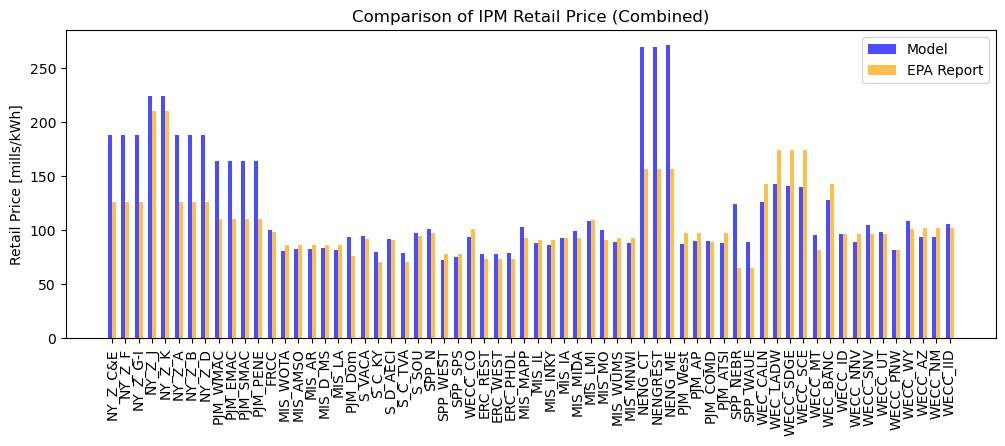

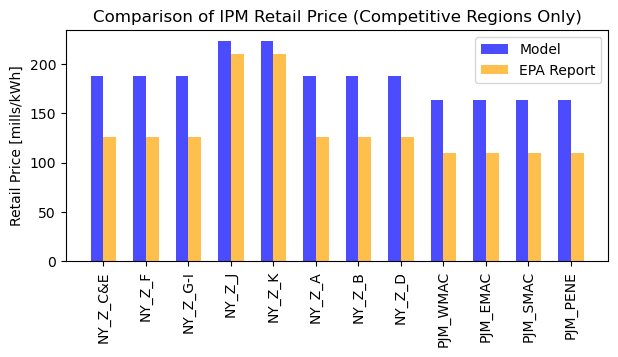

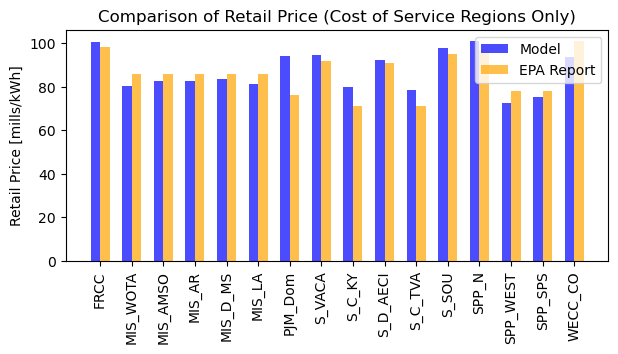

In [181]:
IPM_compare = IPM_compare.set_index('Region')
IPM_final = IPM_final.reset_index()
# Comparison with EPA report
IPM_final[['IPM_Report_Compare [mills/kWh]']] = np.nan

for index, row in IPM_final.iterrows():
    IPM = row['Region']
    print
    NEMS = NEMS_IPM_regions.columns[NEMS_IPM_regions.eq(IPM).any()].tolist()  # List of matching column names
    value = IPM_compare.loc[NEMS, year]
    IPM_final.at[index, 'IPM_Report_Compare [mills/kWh]'] = float(value.iloc[0])

IPM_final['% difference from current model'] = ((IPM_final['IPM_Report_Compare [mills/kWh]'] - IPM_final['Combined Price [mills/kWh]']) / IPM_final['Combined Price [mills/kWh]']) * 100

print('Combined Final Price with EPA Report [mills/kWh]')
display(IPM_final.head())

# Plot with combined price comparison with EPA report
# Bar width
bar_width = 0.3  
x = np.arange(len(IPM_final))  # Position of categories

# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x - bar_width/2, IPM_final['Combined Price [mills/kWh]'], width=bar_width, label='Model', color='blue', alpha=0.7)
ax.bar(x + bar_width/2, IPM_final['IPM_Report_Compare [mills/kWh]'], width=bar_width, label='EPA Report', color='orange', alpha=0.7)

# Labels & Formatting
ax.set_xticks(x)
ax.set_xticklabels(IPM_final['Region'], rotation=90)
ax.set_ylabel('Retail Price [mills/kWh]')
ax.set_title('Comparison of IPM Retail Price (Combined)')
ax.legend()

# Plot with CR price comparison with EPA report
IPM_final_CR = IPM_final[IPM_final['Deregulation Share (%)'] == 100.0]
x_CR = np.arange(len(IPM_final_CR))  # Position of categories

# Create the plot
fig_CR, ax_CR = plt.subplots(figsize=(7, 3))
ax_CR.bar(x_CR - bar_width/2, IPM_final_CR['Competitive Retail [mills/kWh]'], width=bar_width, label='Model', color='blue', alpha=0.7)
ax_CR.bar(x_CR + bar_width/2, IPM_final_CR['IPM_Report_Compare [mills/kWh]'], width=bar_width, label='EPA Report', color='orange', alpha=0.7)

# Labels & Formatting
ax_CR.set_xticks(x_CR)
ax_CR.set_xticklabels(IPM_final_CR['Region'], rotation=90)
ax_CR.set_ylabel('Retail Price [mills/kWh]')
ax_CR.set_title('Comparison of IPM Retail Price (Competitive Regions Only)')
ax_CR.legend()

# Plot with COS price comparison with EPA report
IPM_final_COS = IPM_final[IPM_final['Cost-of-Service Share (%)'] == 100.0]
x_COS = np.arange(len(IPM_final_COS))  # Position of categories

# Create the plot
fig_COS, ax_COS = plt.subplots(figsize=(7, 3))
ax_COS.bar(x_COS - bar_width/2, IPM_final_COS['Cost of Service [mills/kWh]'], width=bar_width, label='Model', color='blue', alpha=0.7)
ax_COS.bar(x_COS + bar_width/2, IPM_final_COS['IPM_Report_Compare [mills/kWh]'], width=bar_width, label='EPA Report', color='orange', alpha=0.7)

# Labels & Formatting
ax_COS.set_xticks(x_COS)
ax_COS.set_xticklabels(IPM_final_COS['Region'], rotation=90)
ax_COS.set_ylabel('Retail Price [mills/kWh]')
ax_COS.set_title('Comparison of Retail Price (Cost of Service Regions Only)')
ax_COS.legend()

# Show plot
plt.show()

# Save as CSV
os.makedirs(folder_path_IPM_COMBINED_COMPARE, exist_ok=True)
filename_IPM_COMBINED_COMPARE = "COMBINED_IPM_COMPARE.csv"
file_path_IPM_COMBINED_COMPARE = os.path.join(folder_path_IPM_COMBINED_COMPARE, filename_IPM_COMBINED_COMPARE)
IPM_final.to_csv(file_path_IPM_COMBINED_COMPARE, index=False)

#### State Level Comparison with EIA Report

State Combined Retail Price Comparison with EIA AEO [mills/kWh]


,State,Combined Price [mills/kWh],Average Retail Price (cents/kWh),Average Retail Price (mills/kWh),% change from current model
0,Alabama,93.098975,11.47,114.7,23.202216
1,Arizona,93.603408,12.19,121.9,30.230301
2,Arkansas,78.539941,9.73,97.3,23.886011
3,California,134.869480,24.87,248.7,84.400504
4,Colorado,93.754008,11.76,117.6,25.434638


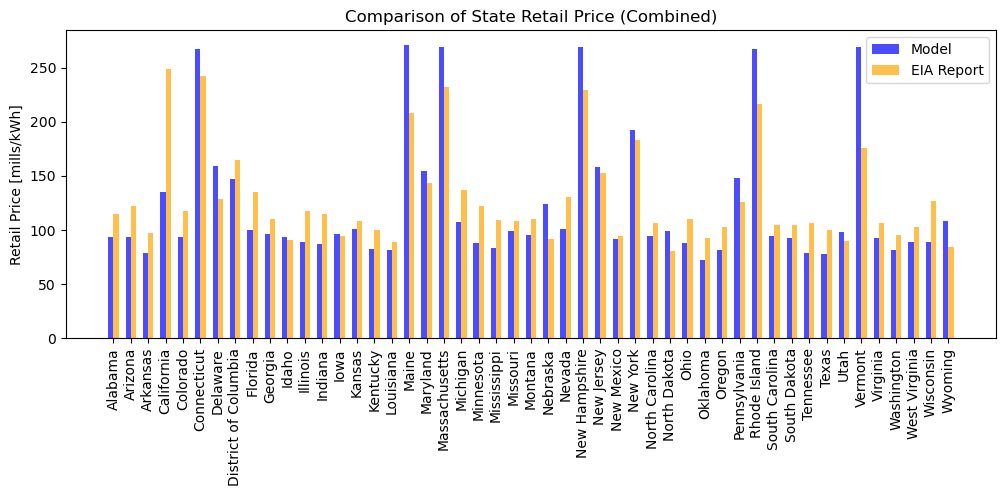

In [182]:
# Comparison with other source
# Drop Alaska and Hawaii
states_compare = states_compare.drop(index=[1,11])

states_compare_combined = pd.merge(states_combined, states_compare, on='State', how='outer')
states_compare_combined['Average Retail Price (mills/kWh)'] = states_compare_combined['Average Retail Price (cents/kWh)'] * 10.0
states_compare_combined['% change from current model'] = ((states_compare_combined['Average Retail Price (mills/kWh)'] - states_compare_combined['Combined Price [mills/kWh]'])/states_compare_combined['Combined Price [mills/kWh]'])*100.0
print('State Combined Retail Price Comparison with EIA AEO [mills/kWh]')
display(states_compare_combined.head())

# Plot with combined price comparison with EPA report
# Bar width
bar_width = 0.3  
x_states = np.arange(len(states_compare_combined))  # Position of categories

# Create the plot
fig_states, ax_states = plt.subplots(figsize=(12, 4))
ax_states.bar(x_states - bar_width/2, states_compare_combined['Combined Price [mills/kWh]'], width=bar_width, label='Model', color='blue', alpha=0.7)
ax_states.bar(x_states + bar_width/2, states_compare_combined['Average Retail Price (mills/kWh)'], width=bar_width, label='EIA Report', color='orange', alpha=0.7)

# Labels & Formatting
ax_states.set_xticks(x_states)
ax_states.set_xticklabels(states_compare_combined['State'], rotation=90)
ax_states.set_ylabel('Retail Price [mills/kWh]')
ax_states.set_title('Comparison of State Retail Price (Combined)')
ax_states.legend()

plt.show()

# Save as CSV
os.makedirs(folder_path_STATES_COMBINED_COMPARE, exist_ok=True)
filename_STATES_COMBINED_COMPARE = "COMBINED_STATES_COMPARE.csv"
file_path_STATES_COMBINED_COMPARE = os.path.join(folder_path_STATES_COMBINED_COMPARE, filename_STATES_COMBINED_COMPARE)
states_compare_combined.to_csv(file_path_STATES_COMBINED_COMPARE, index=False)

### EPA Model Comparison

<div style="text-align: center;">
    <figure>
        <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
          <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">EPA RPM Cost of Service Calculation</span> 
        </figcaption>
        <img src="./files/RPM_COS.png" alt="Energy Cost Formula" width="60%">
    </figure>
</div>

<figure>
  <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Summary of Differences Between EPA RPM and This Model - Cost of Service</span> 
  </figcaption>
  <div style="display: flex; justify-content: center;">
  <table style="width: 75%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px;">
    <thead style="color: black;">
      <tr>
        <th style="padding: 8px; text-align: left;">Cost Component</th>
        <th style="padding: 8px; text-align: left;">Description</th>
      </tr>
    </thead>
    <tbody>
      <tr style="background-color: white;">
        <td style="padding: 8px; font-weight: bold; background-color: white;">Final NUG Cost</td>
        <td style="padding: 8px;">Included within GenX Outputs.</td>
      </tr>
      <tr>
        <td style="padding: 8px; font-weight: bold; background-color: white;">Avg Generation Cost</td>
        <td style="padding: 8px;">Network expansion is included.</td>
      </tr>
    </tbody>
  </table>
</figure>

<div style="margin-top: 15px;">
</div>

<div style="text-align: center;">
    <figure>
        <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
          <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">EPA RPM Competitive Calculation</span> 
        </figcaption>
        <img src="./files/RPM_CR.png" alt="Energy Cost Formula" width="60%">
    </figure>
</div>

<figure>
  <figcaption style="font-size: 0.9em; text-align: center; margin-bottom: 10px; margin-top: 15px">
    <span style="font-size: 1.2em; font-weight: bold; font-style: italic;">Summary of Differences Between EPA RPM and This Model - Competitive</span> 
  </figcaption>
  <div style="display: flex; justify-content: center;">
  <table style="width: 75%; border: 0.1px solid #ddd; border-collapse: collapse; margin-top: 0px; font-size: 13px;">
    <thead style="color: black;">
      <tr>
        <th style="padding: 8px; text-align: left;">Cost Component</th>
        <th style="padding: 8px; text-align: left;">Description</th>
      </tr>
    </thead>
    <tbody>
      <tr style="background-color: #f9f9f9;">
        <td style="padding: 8px; font-weight: bold; background-color: white;">Capacity price</td>
        <td style="padding: 8px;">Calculated with an alternative method using Reserve Margin Revenues.</td>
      </tr>
    </tbody>
  </table>
</figure>